# Thesis Project

- Author 💻✍: Diego Acosta Ugalde
- Description 🖇: This notebook contains all the implementations of my thesis project. The structure can be shown in the Table of Contents.
- Date of creation 📅: 8/Feb/2024

----

MODULES

    1 -> Preprocessing

    2 -> Initial Data Exploration
    
    3 -> Text Representations

    4 -> Topic Recognizion

    5 -> ML Classifiers

    6 -> DL Classifiers

    7 -> Tranformers

## 1: Preprocessing of the raw ECOA data base

In [1]:
# Dependecies
# from google.colab import drive
# from google.colab import files
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
import graphviz

import matplotlib.pyplot as plt

import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

import pandas as pd
import pydotplus

import stanza
from stanza.models.common.doc import Document
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity

from transformers import AutoTokenizer, AutoModelForMaskedLM

from wordcloud import WordCloud

/var/folders/dy/xr0vlym16y5cwngj_4p43nd40000gn/T/ipykernel_4253/453257725.py:18: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/diegoacosta/Documents/Maestría/Thesis/Notebooks/Complete/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Columns that we want to use
columns = ['MET', 'PRA', 'ASE', 'EVA', 'RET', 'APR', 'DOM', 'REC', 'MEJ', 'GÉNERO ALUMNO', 'PROM ACUMULADO EN PROFESIONAL', 'Género del profesor', 'Por qué no lo recomendarias', 'Comentarios']
aspects = ['MET', 'PRA', 'ASE', 'EVA', 'RET', 'APR', 'DOM', 'REC', 'MEJ']

In [3]:
# drive.mount('/content/drive')
# df=pd.read_excel('drive/MyDrive/Tesis/ecoa-demografico.xlsx')
df = pd.read_excel('ecoa-demografico.xlsx')

In [4]:
df.head()

,FOLIO,NOMINA,CRN course reference number,APR,ASE,DOM,EVA,MEJ,MET,PRA,...,% responsabilidad del profesor,Nacionalidad profesor,Campus,Materias que imparte el profesor,Semestres en TEC,Clase en inglés,Grado,TOEFL Profesor,Por qué no lo recomendarias,Comentarios
0,10022293,L00000049,7588,5.0,8.0,4.0,9.0,0.0,5.0,10.0,...,1.0,Mexicana,Monterrey,2.0,10.0,No,MaestrÌa,Mayor o igual 550,"Sabe explicar muy bien las cosas teoricas, per...",NaN
1,10221668,L00000049,7588,10.0,10.0,10.0,8.0,1.0,9.0,8.0,...,1.0,Mexicana,Monterrey,2.0,10.0,No,MaestrÌa,Mayor o igual 550,NaN,NaN
2,11705132,L00000049,7588,5.0,8.0,8.0,8.0,0.0,5.0,7.0,...,1.0,Mexicana,Monterrey,2.0,10.0,No,MaestrÌa,Mayor o igual 550,Método anticuado de enseñar. Los temas podría ...,NaN
3,11705156,L00000049,7588,10.0,10.0,10.0,10.0,0.0,10.0,10.0,...,1.0,Mexicana,Monterrey,2.0,10.0,No,MaestrÌa,Mayor o igual 550,NaN,NaN
4,11706514,L00000049,7588,10.0,10.0,10.0,10.0,0.0,8.0,10.0,...,1.0,Mexicana,Monterrey,2.0,10.0,No,MaestrÌa,Mayor o igual 550,NaN,NaN


In [5]:
print(f'Our original dataset is of shape: {df.shape}')

Our original dataset is of shape: (227746, 44)


In [6]:
df_ecoas = df[columns]
df_ecoas.head()

,MET,PRA,ASE,EVA,RET,APR,DOM,REC,MEJ,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Por qué no lo recomendarias,Comentarios
0,5.0,10.0,8.0,9.0,10.0,5.0,4.0,4.0,0.0,Femenino,94.428,Femenino,"Sabe explicar muy bien las cosas teoricas, per...",NaN
1,9.0,8.0,10.0,8.0,10.0,10.0,10.0,8.0,1.0,Femenino,91.280,Femenino,NaN,NaN
2,5.0,7.0,8.0,8.0,5.0,5.0,8.0,8.0,0.0,Femenino,95.968,Femenino,Método anticuado de enseñar. Los temas podría ...,NaN
3,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,Femenino,88.538,Femenino,NaN,NaN
4,8.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,Femenino,93.981,Femenino,NaN,NaN


In [7]:
pd.options.mode.chained_assignment = None # Disable warning
df_ecoas = df_ecoas.dropna(subset=['Por qué no lo recomendarias', 'Comentarios'], thresh=1) # Delete all rows where there are neither negative or positive comments
df_ecoas['GÉNERO ALUMNO'] = np.where((df_ecoas['GÉNERO ALUMNO'] == 'Femenino'), 0, df_ecoas['GÉNERO ALUMNO'])
df_ecoas['GÉNERO ALUMNO'] = np.where((df_ecoas['GÉNERO ALUMNO'] == 'Masculino'), 1, df_ecoas['GÉNERO ALUMNO'])
df_ecoas['Género del profesor'] = np.where((df_ecoas['Género del profesor'] == 'Femenino'), 0, df_ecoas['Género del profesor'])
df_ecoas['Género del profesor'] = np.where((df_ecoas['Género del profesor'] == 'Masculino'), 1, df_ecoas['Género del profesor'])

In [8]:
for asp in aspects: # We delete all incomplete submissions
  df_ecoas.loc[df_ecoas[asp].isnull(),asp] = 99
  df_ecoas = df_ecoas.loc[df_ecoas[asp] != 99]
df_ecoas = df_ecoas.reset_index(drop=True) # Reset the index

In [9]:
df_ecoas= df_ecoas.rename(columns={"Comentarios": "Positivos"})
df_ecoas= df_ecoas.rename(columns={"Por qué no lo recomendarias": "Negativos"})
p_only = df_ecoas['Positivos'].count()
n_only = df_ecoas['Negativos'].count()
print(f'Tenemos { p_only } comentarios SOLO positivos')
print(f'Tenemos { n_only } comentarios SOLO negativos')

Tenemos 87717 comentarios SOLO positivos
Tenemos 41954 comentarios SOLO negativos


In [10]:
df_ecoas['Tipo Comentario'] = 0
df_ecoas.loc[pd.notna(df_ecoas['Positivos']), 'Tipo Comentario'] = 1
df_ecoas.loc[pd.notna(df_ecoas['Negativos']) & pd.notna(df_ecoas['Positivos']), 'Tipo Comentario'] = 2


In [11]:
df_ecoas['Negativos'] = df_ecoas['Negativos'].fillna('')
df_ecoas['Positivos'] = df_ecoas['Positivos'].fillna('')
df_ecoas["Comentarios"] = df_ecoas["Positivos"] + ' ' + df_ecoas["Negativos"]
df_ecoas = df_ecoas.drop(columns=['Negativos', 'Positivos'])

In [12]:
df_ecoas['AVG'] = df_ecoas[['APR', 'EVA', 'MET', 'PRA', 'REC', 'RET']].mean(axis=1).round(1)

In [13]:
# This is the data set after initial cleaning
df_ecoas.head()

,MET,PRA,ASE,EVA,RET,APR,DOM,REC,MEJ,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Tipo Comentario,Comentarios,AVG
0,5.0,10.0,8.0,9.0,10.0,5.0,4.0,4.0,0.0,0,94.428,0,0,"Sabe explicar muy bien las cosas teoricas, pe...",7.2
1,5.0,7.0,8.0,8.0,5.0,5.0,8.0,8.0,0.0,0,95.968,0,0,Método anticuado de enseñar. Los temas podría...,6.3
2,8.0,10.0,8.0,5.0,10.0,10.0,10.0,10.0,1.0,0,96.408,0,1,"Sabe muchísimo del tema, muy preparada.",8.8
3,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,0,94.981,0,2,buena maestra si lo recomiendo,10.0
4,9.0,9.0,9.0,9.0,9.0,9.0,10.0,9.0,1.0,0,89.040,0,1,Tiene mucho conocimiento sobre los temas.,9.0


### Lemmatization
*In this step we performed some NLP preprocessing techquines such as stop words removal, symbols and special characters removal and lemmatization of the entire comments column*

In [14]:
comments = df_ecoas['Comentarios']

for a in range(len(comments)):
  if type(comments[a]) is not str:
    print(type(comments[a]), 'No es str: ', a)
    df.drop(index=a)

comments = comments.str.lower()

nltk.download('stopwords')
stop = stopwords.words('spanish')
stop.remove('no')
stop.append('es')

# Tokenize the comments
for i in range(len(comments)):
  comments[i] = str(comments[i]).split()
  comments[i] = [word for word in comments[i] if word not in stop]

# Remove the symbols and replace them with blank spaces
sim = "!\"#$%&()*+-.,/:;<=>?@[\]^_`{|}~\n"

# Para cada símbolo, se remplaza por blank space
for c in range(len(comments)):
  for i in range(len(comments[c])):
    for j in sim:
      if comments[c][i].__contains__(j):
        comments[c][i] = comments[c][i].replace(j,'')

comments

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegoacosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0        [sabe, explicar, bien, cosas, teoricas, hace, ...
1        [método, anticuado, enseñar, temas, podría, ha...
2                       [sabe, muchísimo, tema, preparada]
3                         [buena, maestra, si, recomiendo]
4                                    [conocimiento, temas]
                               ...                        
96535    [sabe, materia, gusta, enseñar, no, va, prisa,...
96536       [excelente, profesor, recomiendo, ampliamente]
96537    [profesor, llegó, salvar, semestre, pocas, cla...
96538    [dominio, tema, excelente, profesor, enseña, m...
96539    [triste, solo, pudo, dar, 3, clases, falto, ti...
Name: Comentarios, Length: 96540, dtype: object

In [20]:
total_less2  = 0
total_si = 0
total_no = 0

for comm in comments:
  if len(comm) <2:
    total_less2 += 1
    if 'si' in comm:
      total_si += 1
    if 'no' in comm:
      total_no += 1

print(f'Tenemos {total_less2} comentarios con una sola palabra, sin embargo, no los eliminaremos porque muchos son palabras que pueden ayudar al modelo')
print(f'Tenemos {total_si} comentarios con la palabra "si"')
print(f'Tenemos {total_no} comentarios con la palabra "no"')

Tenemos 2475 comentarios con una sola palabra, sin embargo, no los eliminaremos porque muchos son palabras que pueden ayudar al modelo
Tenemos 82 comentarios con la palabra "si"
Tenemos 30 comentarios con la palabra "no"


In [123]:
comments = list(comments)
for i in range(len(comments)):
  while '' in comments[i]:
    comments[i].remove('')

comentarios_merge=[None]*len(comments)

for i in range(len(comentarios_merge)):
  comentarios_merge[i]=(TreebankWordDetokenizer().detokenize(comments[i]))

print('Example of comment:')
comentarios_merge[2]

Example of comment:


'sabe muchísimo tema preparada'

In [23]:
comments_lemm = []

# Config the Stanza pipeline
config = {
	'processors': 'tokenize,mwt,pos,lemma',
  'lang': 'es',
}
nlp = stanza.Pipeline(**config) # Initialize the pipeline using a configuration dict

2024-02-15 11:42:18 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-02-15 11:42:21 INFO: Loading these models for language: es (Spanish):
| Processor | Package         |
-------------------------------
| tokenize  | ancora          |
| mwt       | ancora          |
| pos       | ancora_charlm   |
| lemma     | ancora_nocharlm |

2024-02-15 11:42:21 INFO: Using device: cpu
2024-02-15 11:42:21 INFO: Loading: tokenize
2024-02-15 11:42:21 INFO: Loading: mwt
2024-02-15 11:42:21 INFO: Loading: pos
2024-02-15 11:42:21 INFO: Loading: lemma
2024-02-15 11:42:21 INFO: Done loading processors!


In [20]:
import concurrent.futures

com_lemmatized = []
comments_lemm = []

def lemmatize_comments(comment):
  doc = nlp(comment)
  lemmatized_comment = []

  for sent in doc.sentences:
    lemmatized_comment.extend([word.lemma for word in sent.words])
  return lemmatized_comment

with concurrent.futures.ThreadPoolExecutor() as executor:
  results = executor.map(lemmatize_comments, comentarios_merge)

comments_lemm = list(results)


In [21]:
print('Example of comment after lemmatizaion:')
comments_lemm[2]

Example of comment after lemmatizaion:


['saber', 'muchísimo', 'tema', 'preparado']

In [23]:
df_ecoas['Lemm'] = comments_lemm
df_ecoas.tail()

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Tipo Comentario,Comentarios,AVG,Lemm
96535,8.0,9.0,8.0,0.0,8.0,8.0,5.0,8.0,9.0,0,94.288,1,2,"Sabe mucho de la materia y le gusta enseñar, n...",7.5,"[saber, materia, gustar, enseñar, no, ir, pris..."
96536,10.0,10.0,10.0,1.0,10.0,10.0,10.0,10.0,10.0,1,80.660,1,2,excelente profesor lo recomiendo ampliamente,10.0,"[excelente, profesor, recomer, ampliamente]"
96537,6.0,7.0,5.0,0.0,5.0,4.0,5.0,8.0,7.0,1,89.843,1,2,"El profesor llegó a salvar el semestre, las po...",5.5,"[profesor, llegar, salvar, semestre, poco, cla..."
96538,10.0,10.0,10.0,1.0,10.0,10.0,10.0,10.0,10.0,0,92.559,1,1,"Dominio del tema, excelente profesor, enseña d...",10.0,"[dominio, tema, excelente, profesor, enseñar, ..."
96539,10.0,10.0,10.0,1.0,9.0,8.0,10.0,10.0,8.0,0,93.150,1,1,Que triste que solo me pudo dar 3 clases. Falt...,9.5,"[triste, solo, poder, dar, 3, clase, falto, ti..."


In [24]:
df_ecoas.shape

(96540, 16)

In [25]:
df_ecoas.tail()

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Tipo Comentario,Comentarios,AVG,Lemm
96535,8.0,9.0,8.0,0.0,8.0,8.0,5.0,8.0,9.0,0,94.288,1,2,"Sabe mucho de la materia y le gusta enseñar, n...",7.5,"[saber, materia, gustar, enseñar, no, ir, pris..."
96536,10.0,10.0,10.0,1.0,10.0,10.0,10.0,10.0,10.0,1,80.660,1,2,excelente profesor lo recomiendo ampliamente,10.0,"[excelente, profesor, recomer, ampliamente]"
96537,6.0,7.0,5.0,0.0,5.0,4.0,5.0,8.0,7.0,1,89.843,1,2,"El profesor llegó a salvar el semestre, las po...",5.5,"[profesor, llegar, salvar, semestre, poco, cla..."
96538,10.0,10.0,10.0,1.0,10.0,10.0,10.0,10.0,10.0,0,92.559,1,1,"Dominio del tema, excelente profesor, enseña d...",10.0,"[dominio, tema, excelente, profesor, enseñar, ..."
96539,10.0,10.0,10.0,1.0,9.0,8.0,10.0,10.0,8.0,0,93.150,1,1,Que triste que solo me pudo dar 3 clases. Falt...,9.5,"[triste, solo, poder, dar, 3, clase, falto, ti..."


In [26]:
df_ecoas.to_csv('df_ready.csv')

## 2: Initial Data Exploration

In this section we explore the dataset to reveal some of their characteristics.

First, a correlation analysis between the quantitative data is performed to reveal the relationship between some educational aspects and other variables like gender and overall mean (promedio acumulado).

In the second place, an alysis of the scores for the educational aspects on their distribution.

In third place, we move to the text to perform the initial exploration of the comments using Term Frequency Inverse Document Frequency (TF-IDF) and use that text representation to create a Word Cloud.

Lastly, we performed a Latent Dirichlet Allocation (LDA) analysis to observe if the LDA algorithm is capable of observe 8 categories/topics (in this case, educational aspects) and the coherience metrics that results from that analysis.

### Correlation Analysis

Using Perason and Point-biserial correlation coefficients.

In [5]:
df_ecoas=pd.read_csv('df_ready.csv', index_col=0)
df_ecoas.head()

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Tipo Comentario,Comentarios,AVG,Lemm
0,5.0,4.0,9.0,0.0,5.0,10.0,4.0,10.0,8.0,0,94.428,0.0,0,"Sabe explicar muy bien las cosas teoricas, pe...",7.2,"['saber', 'explicar', 'bien', 'cosa', 'teorico..."
1,5.0,8.0,8.0,0.0,5.0,7.0,8.0,5.0,8.0,0,95.968,0.0,0,Método anticuado de enseñar. Los temas podría...,6.3,"['método', 'anticuado', 'enseñar', 'tema', 'po..."
2,10.0,10.0,5.0,1.0,8.0,10.0,10.0,10.0,8.0,0,96.408,0.0,1,"Sabe muchísimo del tema, muy preparada.",8.8,"['saber', 'muchísimo', 'tema', 'preparado']"
3,10.0,10.0,10.0,1.0,10.0,10.0,10.0,10.0,10.0,0,94.981,0.0,2,buena maestra si lo recomiendo,10.0,"['buen', 'maestro', 'si', 'recomer']"
4,9.0,10.0,9.0,1.0,9.0,9.0,9.0,9.0,9.0,0,89.040,0.0,1,Tiene mucho conocimiento sobre los temas.,9.0,"['conocimiento', 'tema']"


In [6]:
comments = df_ecoas['Comentarios']

for a in range(len(comments)):
  if type(comments[a]) is not str:
    print(type(comments[a]), 'No es str: ', a)
    df.drop(index=a)

comments = comments.str.lower()

nltk.download('stopwords')
stop = stopwords.words('spanish')
stop.remove('no')
stop.append('es')

# Tokenize the comments
for i in range(len(comments)):
  comments[i] = str(comments[i]).split()
  comments[i] = [word for word in comments[i] if word not in stop]

# Remove the symbols and replace them with blank spaces
sim = "!\"#$%&()*+-.,/:;<=>?@[\]^_`{|}~\n"

# Para cada símbolo, se remplaza por blank space
for c in range(len(comments)):
  for i in range(len(comments[c])):
    for j in sim:
      if comments[c][i].__contains__(j):
        comments[c][i] = comments[c][i].replace(j,'')

comments

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegoacosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0        [sabe, explicar, bien, cosas, teoricas, hace, ...
1        [método, anticuado, enseñar, temas, podría, ha...
2                       [sabe, muchísimo, tema, preparada]
3                         [buena, maestra, si, recomiendo]
4                                    [conocimiento, temas]
                               ...                        
96535    [sabe, materia, gusta, enseñar, no, va, prisa,...
96536       [excelente, profesor, recomiendo, ampliamente]
96537    [profesor, llegó, salvar, semestre, pocas, cla...
96538    [dominio, tema, excelente, profesor, enseña, m...
96539    [triste, solo, pudo, dar, 3, clases, falto, ti...
Name: Comentarios, Length: 96540, dtype: object

In [7]:
df_ecoas.corr(numeric_only=True)

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Tipo Comentario,AVG
APR,1.000000,0.705294,0.747454,0.520176,0.820568,0.786701,0.820007,0.779791,0.793709,-0.009340,0.000545,-0.017019,0.174272,0.924369
DOM,0.705294,1.000000,0.622844,0.386209,0.676982,0.676210,0.647179,0.676787,0.659833,-0.007940,0.009622,0.008138,0.150319,0.744898
EVA,0.747454,0.622844,1.000000,0.431899,0.734603,0.713663,0.706276,0.690902,0.725207,-0.007620,0.007781,-0.022037,0.127560,0.852260
MEJ,0.520176,0.386209,0.431899,1.000000,0.553982,0.485600,0.584817,0.475533,0.435738,-0.014627,-0.036287,0.009828,0.066324,0.572997
MET,0.820568,0.676982,0.734603,0.553982,1.000000,0.836535,0.810059,0.758998,0.753400,0.003939,-0.014612,-0.020835,0.150852,0.922863
PRA,0.786701,0.676210,0.713663,0.485600,0.836535,1.000000,0.746817,0.734674,0.735511,-0.003888,0.003705,-0.021157,0.139490,0.892518
REC,0.820007,0.647179,0.706276,0.584817,0.810059,0.746817,1.000000,0.712234,0.715627,0.007141,-0.016392,-0.009404,0.198173,0.905530
RET,0.779791,0.676787,0.690902,0.475533,0.758998,0.734674,0.712234,1.000000,0.691238,-0.016507,-0.008949,0.000912,0.138986,0.866408
ASE,0.793709,0.659833,0.725207,0.435738,0.753400,0.735511,0.715627,0.691238,1.000000,-0.010055,0.022699,-0.014326,0.144428,0.821573
GÉNERO ALUMNO,-0.009340,-0.007940,-0.007620,-0.014627,0.003939,-0.003888,0.007141,-0.016507,-0.010055,1.000000,-0.172352,0.067672,0.019115,-0.004185


In [8]:
df_ecoas['MEJ'].value_counts() # Now lets focus on binary variables. MEJ

MEJ
1.0    63162
0.0    33378
Name: count, dtype: int64

In [7]:
df_ecoas[['APR', 'DOM', 'EVA', 'MET', 'PRA', 'REC', 'RET', 'ASE', 'AVG']].corrwith(df_ecoas['MEJ'], method=stats.pointbiserialr)

,APR,DOM,EVA,MET,PRA,REC,RET,ASE,AVG
0,0.520176,0.386209,0.431899,0.553982,0.4856,0.584817,0.475533,0.435738,0.572997
1,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000


In [8]:
df_ecoas['GÉNERO ALUMNO'].value_counts()

GÉNERO ALUMNO
1    50878
0    45662
Name: count, dtype: int64

In [9]:
df_ecoas[['APR', 'DOM', 'EVA', 'MEJ', 'MET', 'PRA', 'REC', 'RET', 'ASE', 'AVG']].corrwith(df_ecoas['GÉNERO ALUMNO'], method=stats.pointbiserialr)

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE,AVG
0,-0.009340,-0.007940,-0.007620,-0.014627,0.003939,-0.003888,0.007141,-1.650675e-02,-0.010055,-0.004185
1,0.003709,0.013618,0.017904,0.000005,0.220966,0.227074,0.026506,2.911677e-07,0.001783,0.193507


In [10]:
df_ecoas['Género del profesor'].value_counts()

Género del profesor
1.0    56013
0.0    40062
Name: count, dtype: int64

In [11]:
df_ecoas[['APR', 'DOM', 'EVA', 'MET', 'PRA', 'REC', 'RET', 'AVG']].corrwith(df_ecoas['Género del profesor'])

APR   -0.017019
DOM    0.008138
EVA   -0.022037
MET   -0.020835
PRA   -0.021157
REC   -0.009404
RET    0.000912
AVG   -0.016420
dtype: float64

### Distribution Analysis

*We are using the Kernel Density Estimation, which is a non-parametric way to estimate the probability density function (PDF) of a random variable. This method is used to get a smooth curve (function) that is a good guess of the distribution of a set of data*

*As we can observe, the distribution of the average scores is highly umbalanced.*

<Axes: ylabel='Density'>

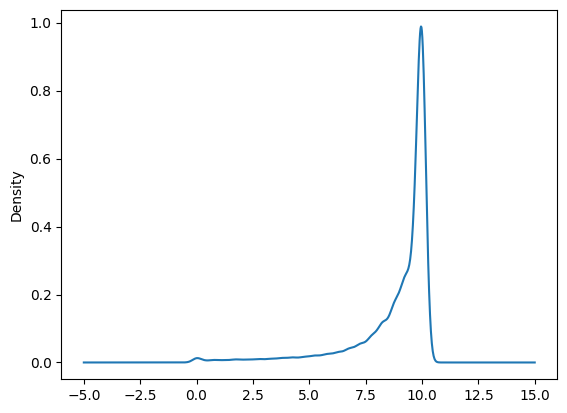

In [12]:
df_ecoas['AVG'].plot(kind='kde')

<Axes: ylabel='Density'>

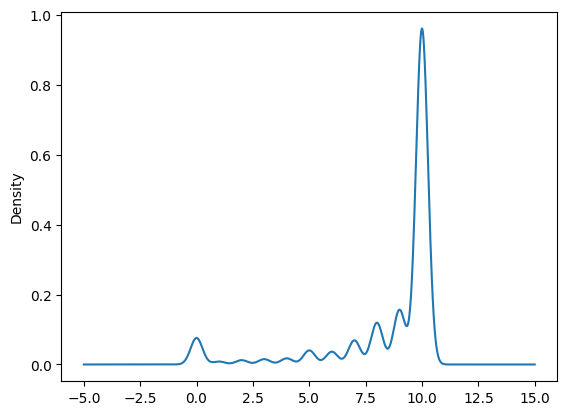

In [13]:
df_ecoas['REC'].plot(kind='kde')

*For the question "Would you consider this professors as one of the best you have ever had?", measured by the aspect MEJ, we can observe that the umbalance also exists but not in the same distribution as the AVG score.*

*This motivated us to perform a threshold for the AVG score and observe if the umbalance could follow a similar distribution like the one below.*

*Remember that the MEJ aspect has:*
- *Considered as on the bests -> 63,162*
- *Not considered as on the bests -> 33,378*

In [14]:
yes = 63162
no = 33378
total = yes + no
print(f'The percentage of YES is: {round(yes/total*100,2)}%')
print(f'The percentage of NO is: {round(no/total*100,2)}%')

The percentage of YES is: 65.43%
The percentage of NO is: 34.57%


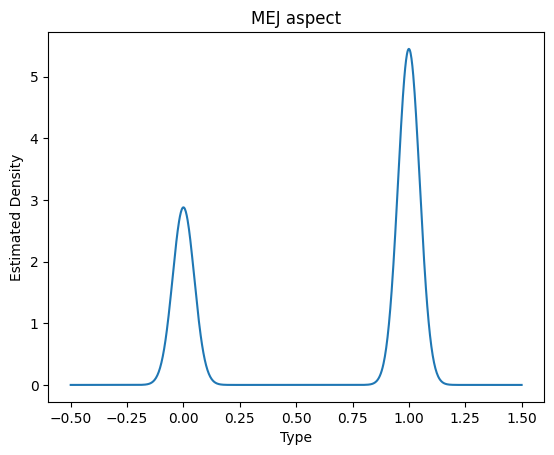

In [15]:
df_ecoas['MEJ'].plot(kind='kde')
# plt.legend(title='Type of comment')
plt.title("MEJ aspect")
plt.xlabel("Type")
plt.ylabel("Estimated Density")
plt.savefig('MEJ_kde.png', dpi=300)
plt.show()

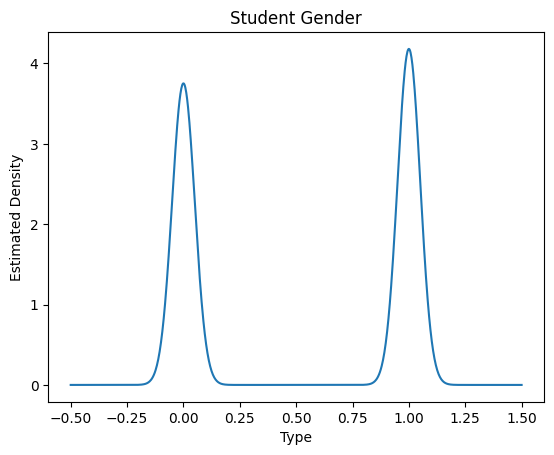

In [16]:
df_ecoas['GÉNERO ALUMNO'].plot(kind='kde')
# plt.legend(title='Type of comment')
plt.title("Student Gender")
plt.xlabel("Type")
plt.ylabel("Estimated Density")
plt.savefig('student_gender_kde.png', dpi=300)
plt.show()

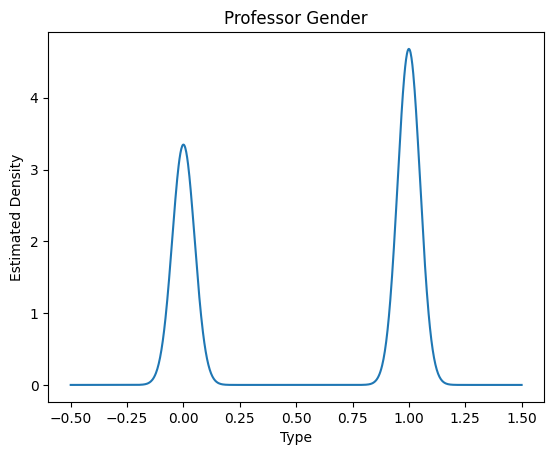

In [17]:
df_ecoas['Género del profesor'].plot(kind='kde')
# plt.legend(title='Type of comment')
plt.title("Professor Gender")
plt.xlabel("Type")
plt.ylabel("Estimated Density")
plt.savefig('professor_gender_kde.png', dpi=300)
plt.show()

*There is another imbalance in the "kind of comment" label, the majority of students wrote positive-only comments (1), followed by positive-and-negative comments (2) and only a small portion of the students wrote negative-only (0) comments.*

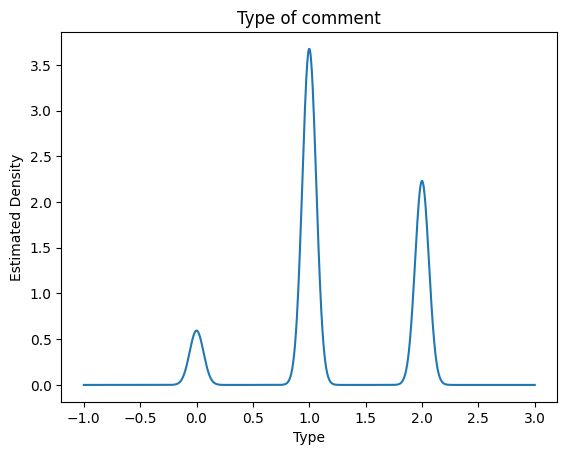

In [18]:
df_ecoas['Tipo Comentario'].plot(kind='kde')
# plt.legend(title='Type of comment')
plt.title("Type of comment")
plt.xlabel("Type")
plt.ylabel("Estimated Density")
plt.savefig('typecomm.png', dpi=300)
plt.show()

In [19]:
df_ecoas.head()

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Tipo Comentario,Comentarios,AVG,Lemm
0,5.0,4.0,9.0,0.0,5.0,10.0,4.0,10.0,8.0,0,94.428,0.0,0,"Sabe explicar muy bien las cosas teoricas, pe...",7.2,"['saber', 'explicar', 'bien', 'cosa', 'teorico..."
1,5.0,8.0,8.0,0.0,5.0,7.0,8.0,5.0,8.0,0,95.968,0.0,0,Método anticuado de enseñar. Los temas podría...,6.3,"['método', 'anticuado', 'enseñar', 'tema', 'po..."
2,10.0,10.0,5.0,1.0,8.0,10.0,10.0,10.0,8.0,0,96.408,0.0,1,"Sabe muchísimo del tema, muy preparada.",8.8,"['saber', 'muchísimo', 'tema', 'preparado']"
3,10.0,10.0,10.0,1.0,10.0,10.0,10.0,10.0,10.0,0,94.981,0.0,2,buena maestra si lo recomiendo,10.0,"['buen', 'maestro', 'si', 'recomer']"
4,9.0,10.0,9.0,1.0,9.0,9.0,9.0,9.0,9.0,0,89.040,0.0,1,Tiene mucho conocimiento sobre los temas.,9.0,"['conocimiento', 'tema']"


#### Using a threshold to change the data distribution
*We will use a scale to define a threshold and change the values in the aspects from a 11-point scale to binary variables*

In [20]:
scales = [[0, 9, 0], [9.1, 10, 1]]
scales

[[0, 9, 0], [9.1, 10, 1]]

In [21]:
aspects.append('AVG')
aspects.remove('MEJ') # we remove MEJ because we don't want to use the scale on that column
aspects

['MET', 'PRA', 'ASE', 'EVA', 'RET', 'APR', 'DOM', 'REC', 'AVG']

In [22]:
df_before_scale = df_ecoas.copy() # We save a dataframe copy just in case

In [23]:
for asp in aspects:
    for sc in scales:
        df_ecoas[asp] = np.where((df_ecoas[asp] >= sc[0]) & (df_ecoas[asp] <= sc[1]), sc[2], df_ecoas[asp])
df_ecoas = df_ecoas.reset_index(drop=True)
df_ecoas.head()

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Tipo Comentario,Comentarios,AVG,Lemm
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,94.428,0.0,0,"Sabe explicar muy bien las cosas teoricas, pe...",0.0,"['saber', 'explicar', 'bien', 'cosa', 'teorico..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,95.968,0.0,0,Método anticuado de enseñar. Los temas podría...,0.0,"['método', 'anticuado', 'enseñar', 'tema', 'po..."
2,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0,96.408,0.0,1,"Sabe muchísimo del tema, muy preparada.",0.0,"['saber', 'muchísimo', 'tema', 'preparado']"
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,94.981,0.0,2,buena maestra si lo recomiendo,1.0,"['buen', 'maestro', 'si', 'recomer']"
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,89.040,0.0,1,Tiene mucho conocimiento sobre los temas.,0.0,"['conocimiento', 'tema']"


*Now all the columns are more or less in the same proportions*

In [24]:
for asp in aspects:
  print(df_ecoas[asp].value_counts(normalize = True))
  print('- - - - - - - - - - - - ')
# MEJ is not in aspects so we print it separated
print(df_ecoas['MEJ'].value_counts(normalize = True))
print('- - - - - - - - - - - - ')

MET
1.0    0.553543
0.0    0.446457
Name: proportion, dtype: float64
- - - - - - - - - - - - 
PRA
1.0    0.592863
0.0    0.407137
Name: proportion, dtype: float64
- - - - - - - - - - - - 
ASE
1.0    0.679946
0.0    0.320054
Name: proportion, dtype: float64
- - - - - - - - - - - - 
EVA
1.0    0.61417
0.0    0.38583
Name: proportion, dtype: float64
- - - - - - - - - - - - 
RET
1.0    0.627056
0.0    0.372944
Name: proportion, dtype: float64
- - - - - - - - - - - - 
APR
1.0    0.634359
0.0    0.365641
Name: proportion, dtype: float64
- - - - - - - - - - - - 
DOM
1.0    0.791838
0.0    0.208162
Name: proportion, dtype: float64
- - - - - - - - - - - - 
REC
1.0    0.635788
0.0    0.364212
Name: proportion, dtype: float64
- - - - - - - - - - - - 
AVG
1.0    0.659364
0.0    0.340636
Name: proportion, dtype: float64
- - - - - - - - - - - - 
MEJ
1.0    0.654257
0.0    0.345743
Name: proportion, dtype: float64
- - - - - - - - - - - - 


*This is how the distribution of the data set looked before.*

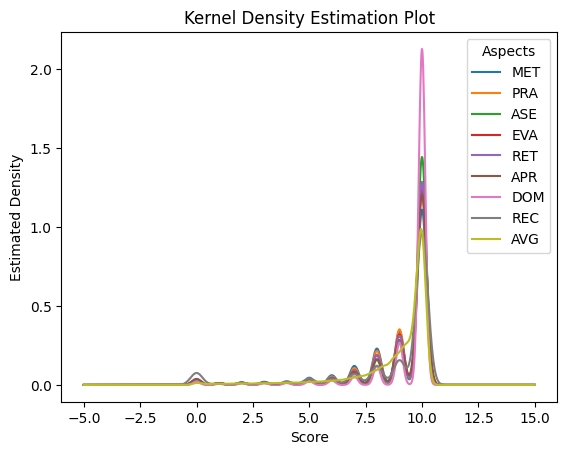

In [25]:
df_before_scale[aspects].plot(kind='kde')
# Add legend to plot
plt.title('Kernel Density Estimation Plot')
plt.legend(aspects, title='Aspects')
plt.xlabel("Score")
plt.ylabel("Estimated Density")
plt.savefig('initial_distribution_kde.png', dpi=300)
plt.show()

Using a threshold, help us in reducing the variability since as shown before, that highly correlated values are not beneficial for the model. The distribution shape will change completely, and will now have a binomial-like distribution where the data points are categorized into one of two groups 0 or 1

In [26]:
aspects.append('MEJ')
aspects

['MET', 'PRA', 'ASE', 'EVA', 'RET', 'APR', 'DOM', 'REC', 'AVG', 'MEJ']

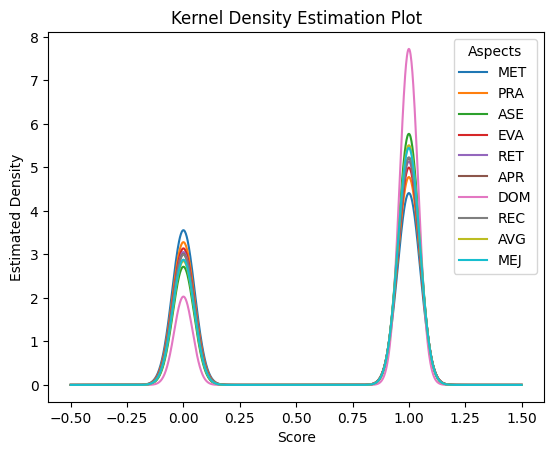

In [27]:
df_ecoas[aspects].plot(kind='kde')
# Add legend to plot
plt.title('Kernel Density Estimation Plot')
plt.legend(aspects, title='Aspects')
plt.xlabel("Score")
plt.ylabel("Estimated Density")
plt.savefig('scaled_distribution_kde.png', dpi=300)
plt.show()

The loss of information is evidenced in the new correlation matrix after the threshold is applied. As we can see, the data is now less correlated.

In [28]:
df_ecoas[aspects].corr(numeric_only=True)

,MET,PRA,ASE,EVA,RET,APR,DOM,REC,AVG,MEJ
MET,1.000000,0.678493,0.586884,0.595120,0.591797,0.652667,0.481867,0.643885,0.722244,0.515698
PRA,0.678493,1.000000,0.585748,0.587389,0.585109,0.627789,0.497040,0.576138,0.692816,0.451169
ASE,0.586884,0.585748,1.000000,0.594202,0.562146,0.640972,0.525602,0.553703,0.636778,0.424440
EVA,0.595120,0.587389,0.594202,1.000000,0.564576,0.603655,0.476445,0.545489,0.662359,0.397419
RET,0.591797,0.585109,0.562146,0.564576,1.000000,0.639670,0.523072,0.542073,0.667774,0.450993
APR,0.652667,0.627789,0.640972,0.603655,0.639670,1.000000,0.559006,0.650932,0.749716,0.522158
DOM,0.481867,0.497040,0.525602,0.476445,0.523072,0.559006,1.000000,0.519374,0.566323,0.422767
REC,0.643885,0.576138,0.553703,0.545489,0.542073,0.650932,0.519374,1.000000,0.754702,0.599114
AVG,0.722244,0.692816,0.636778,0.662359,0.667774,0.749716,0.566323,0.754702,1.000000,0.589248
MEJ,0.515698,0.451169,0.424440,0.397419,0.450993,0.522158,0.422767,0.599114,0.589248,1.000000


## 3: Text Representations
We will generate different text representations of the comments: TF-IDF, Word Embeddings and Transformers Encoding

### 3.1:TF-IDF
Term Frequency Inverse Document Frequency

In [9]:
df_ecoas.head()

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Tipo Comentario,Comentarios,AVG,Lemm
0,5.0,4.0,9.0,0.0,5.0,10.0,4.0,10.0,8.0,0,94.428,0.0,0,"Sabe explicar muy bien las cosas teoricas, pe...",7.2,"['saber', 'explicar', 'bien', 'cosa', 'teorico..."
1,5.0,8.0,8.0,0.0,5.0,7.0,8.0,5.0,8.0,0,95.968,0.0,0,Método anticuado de enseñar. Los temas podría...,6.3,"['método', 'anticuado', 'enseñar', 'tema', 'po..."
2,10.0,10.0,5.0,1.0,8.0,10.0,10.0,10.0,8.0,0,96.408,0.0,1,"Sabe muchísimo del tema, muy preparada.",8.8,"['saber', 'muchísimo', 'tema', 'preparado']"
3,10.0,10.0,10.0,1.0,10.0,10.0,10.0,10.0,10.0,0,94.981,0.0,2,buena maestra si lo recomiendo,10.0,"['buen', 'maestro', 'si', 'recomer']"
4,9.0,10.0,9.0,1.0,9.0,9.0,9.0,9.0,9.0,0,89.040,0.0,1,Tiene mucho conocimiento sobre los temas.,9.0,"['conocimiento', 'tema']"


In [10]:
from ast import literal_eval
df_ecoas['Lemm'] = df_ecoas['Lemm'].apply(literal_eval)

In [11]:
commentsL = df_ecoas['Lemm']

In [12]:
# Merge comments
comentarios_merge=[None]*len(commentsL)
for i in range(len(commentsL)):
  comentarios_merge[i]=(TreebankWordDetokenizer().detokenize(list(commentsL[i])))

In [13]:
comentarios_merge[2]

'saber muchísimo tema preparado'

In [14]:
aspects_classes = df_ecoas.drop(columns=['Comentarios', 'Lemm', 'Género del profesor', 'GÉNERO ALUMNO', 'PROM ACUMULADO EN PROFESIONAL','Tipo Comentario', 'AVG', 'MEJ'])
aspects_classes.head()

,APR,DOM,EVA,MET,PRA,REC,RET,ASE
0,5.0,4.0,9.0,5.0,10.0,4.0,10.0,8.0
1,5.0,8.0,8.0,5.0,7.0,8.0,5.0,8.0
2,10.0,10.0,5.0,8.0,10.0,10.0,10.0,8.0
3,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
4,9.0,10.0,9.0,9.0,9.0,9.0,9.0,9.0


In [15]:
comments_train,comments_test,aspects_train, aspects_test = train_test_split(comentarios_merge, aspects_classes, test_size=0.25, random_state=30)
print('Train:', 'Comentarios->', len(comments_train), 'Aspectos->',  aspects_train.shape, '\nTest:', 'Comentarios->', len(comments_test),'Aspectos->', aspects_test.shape)

Train: Comentarios-> 72405 Aspectos-> (72405, 8) 
Test: Comentarios-> 24135 Aspectos-> (24135, 8)


In [36]:
comments_train[:5]

['buen proyecto',
 'excelente profesor',
 'tomar clase ir recordar clase secundario lamentablemente manuel soto ser peor profesor año tec impartir curso peor manera posible semestre consistir presentación compañero cada tema curso profesor dar retroalimentación alguno comentario técnico interesante renunciar así todo responsabilidad enseñanza afortunadamente dado falta tema profesor impartir dos clase cual bajo calidad posible pues solo proyección vídeo breve parafraseo profesor suma evaluación consistir llenar espacio blanco textualmente mismo presentación enviar ejercicio bajo nivel resumen evidente falta interés profesor impartir materia potencial aprendizaje curso ser perdido culpa profesor no querer volver tomar clase profesor pues gustar formación académico calidad necesitar profesor universitario no secundario profesor manuel soto licón no merecer tec monterrey',
 'ademar conocimiento programa responder duda instante pregunta',
 'inteligente saber explicar bien dificultad']

In [37]:
vectorizer = TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(comments_train)
tf_x_test = vectorizer.transform(comments_test)

tf_idf = pd.DataFrame(tf_x_train.todense())
tf_idf.columns = vectorizer.get_feature_names_out()
tf_idf_matrix = tf_idf.T

tf_idf_matrix['Count'] = tf_idf_matrix.sum(axis=1)

# Top 15 words with the highest count
tf_idf_matrix = tf_idf_matrix.sort_values(by='Count', ascending=False).head(15)

print(tf_idf_matrix.drop(columns='Count').head(15))

                 0         1         2         3         4         5      \
buen          0.462317  0.000000  0.000000  0.000000  0.000000  0.000000   
clase         0.000000  0.000000  0.097404  0.000000  0.000000  0.000000   
no            0.000000  0.000000  0.085803  0.000000  0.000000  0.128508   
maestro       0.000000  0.000000  0.000000  0.000000  0.000000  0.152801   
explicar      0.000000  0.000000  0.000000  0.000000  0.267556  0.000000   
tema          0.000000  0.000000  0.060333  0.000000  0.000000  0.000000   
profesor      0.000000  0.669321  0.300372  0.000000  0.000000  0.000000   
excelente     0.000000  0.742973  0.000000  0.000000  0.000000  0.166459   
bien          0.000000  0.000000  0.000000  0.000000  0.286761  0.000000   
saber         0.000000  0.000000  0.000000  0.000000  0.291975  0.000000   
materia       0.000000  0.000000  0.034930  0.000000  0.000000  0.000000   
hacer         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
si          

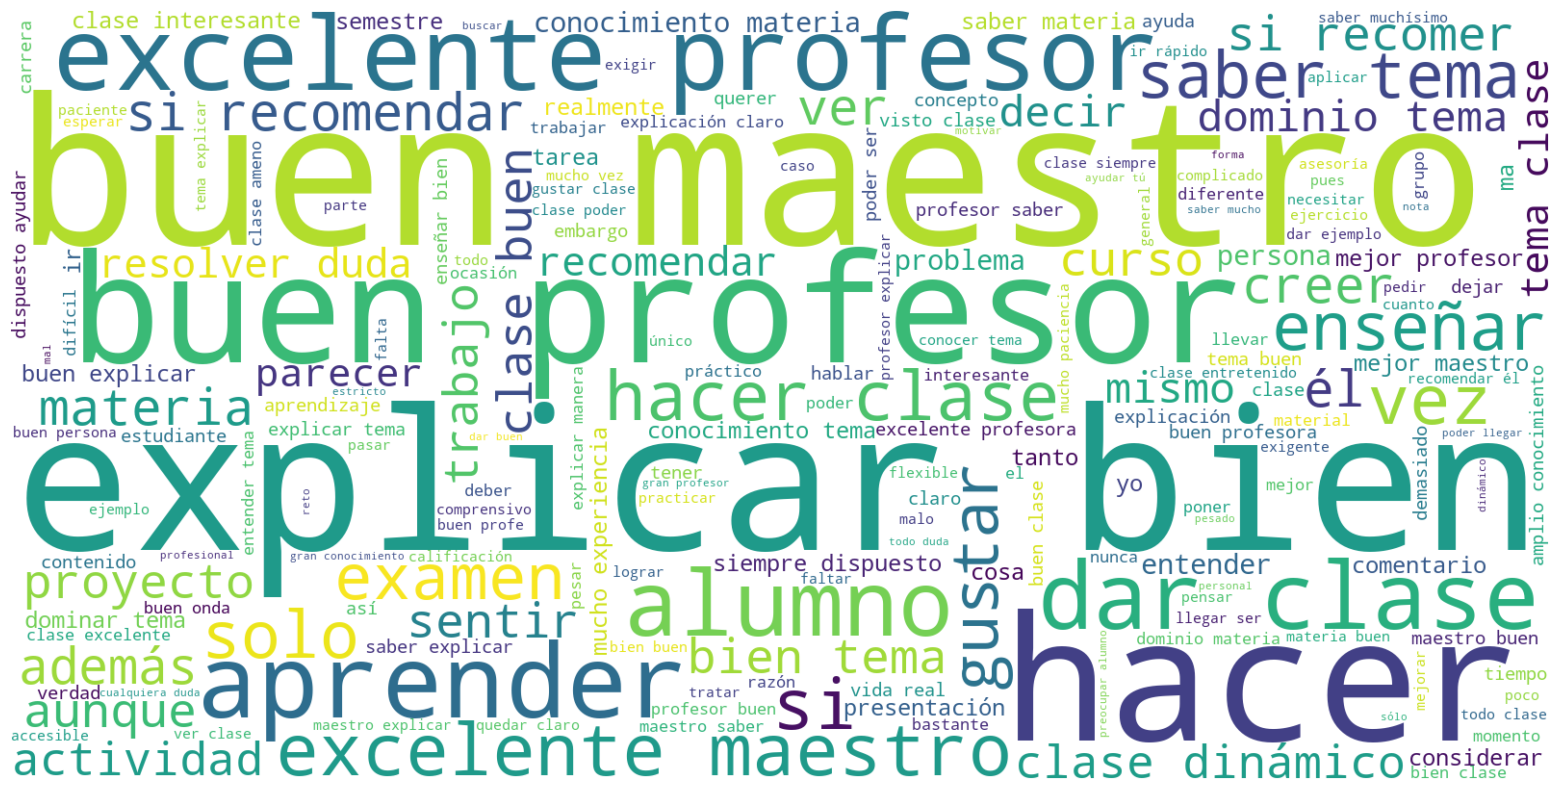

In [38]:
# Wordcloud
# Combine all the text data into a single string
text_data = ' '.join(comments_train)

# Create a WordCloud object
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(text_data)

# Display the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('WordCloud_TFIDF.png', dpi=300)
plt.show()

### 3.2:Word-Embeddings

In [39]:
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Train Word2Vec model on the comments
model = Word2Vec(sentences=comments, vector_size=100, window=5, min_count=1, workers=4)

# You can access the word vectors using the 'wv' attribute of the model
word_vectors = model.wv

# Get the vector representation of a word
vector = word_vectors['maestro']
# print(vector)
# Find similar words
similar_words = word_vectors.most_similar('maestro')
print(f'This are the most similar words to `maestro`: {similar_words}')

This are the most similar words to `maestro`: [('profesor', 0.9232883453369141), ('profe', 0.8418406248092651), ('tealmente', 0.7420955896377563), ('programador', 0.7419736385345459), ('humor', 0.7095018625259399), ('aplicamiemto', 0.6945813298225403), ('estimulador', 0.6686493158340454), ('agente', 0.6657515168190002), ('creara', 0.6591225862503052), ('prof', 0.6370187997817993)]


In [40]:
# Other similar words
similar_words = word_vectors.most_similar('dominio')
print(f'This are the most similar words to `dominio`: {similar_words}')

similar_words = word_vectors.most_similar('actividad')
print(f'This are the most similar words to `actividad`: {similar_words}')

This are the most similar words to `dominio`: [('conocimiento', 0.83743816614151), ('manejo', 0.7697607278823853), ('domino', 0.7580644488334656), ('domina', 0.7420540452003479), ('experto', 0.7127390503883362), ('domio', 0.683928906917572), ('experta', 0.677566409111023), ('entendimiento', 0.6752116680145264), ('conocedor', 0.6685920357704163), ('conoce', 0.6389334201812744)]
This are the most similar words to `actividad`: [('semana', 0.8837703466415405), ('capitulo', 0.8580513596534729), ('ejercicio', 0.8553908467292786), ('quiz', 0.8520174026489258), ('reporte', 0.8361246585845947), ('días', 0.8319721221923828), ('después', 0.8297199010848999), ('casa', 0.8114980459213257), ('equipos', 0.8109456896781921), ('parcial', 0.8088531494140625)]


In [41]:
# Function to flatten the list of lists
def flatten_list(l):
    return [item for sublist in l for item in sublist]

In [42]:
# Aspects keywords
MET_keywords = 'innovación tecnología herramientas explicaciones claridad precisión medios técnicas apoyo facilitación estilos ritmos aprendizaje recursos digitales aplicaciones interactivas plataformas educativas en línea dinámico participativo estrategias adaptación educación efectiva avanzadas enriquecimiento experiencia metodología actividades instructor estudiantes recursos digitales innovadoras tecnológicas estratégicas adaptativas participación'
PRA_keywords = 'casos proyectos problemas prácticas laboratorios talleres empresas organizaciones interacción profesionales teoría desafíos mundo real habilidades prácticas críticas resolución aplicación consolidación enfoque conocimiento preparación fomento desarrollo campo retos experiencia aprendizaje activo inmersión profundización comprensión contextualización aplicada realidad dinamismo pragmatismo soluciones'
ASE_keywords = 'interacción asesoría proceso éxito disponibilidad medios horarios ambiente respeto abierto apoyo dudas confianza profundo significativo potencial desarrollo profesor estudiantes entorno confianza motivación comprensión orientación consultas retroalimentación crecimiento diálogo comunicación empatía resolución preguntas accesibilidad dedicación involucramiento participación escucha asesoramiento'
EVA_keywords = 'evaluación retroalimentación fortalezas debilidades herramientas justa equitativa políticas criterios continua pruebas trabajos presentaciones orales progreso desarrollo mejora sistema integral métodos entendimiento contribución estudiante fomento calificación desempeño objetivos logros aprendizaje feedback autoevaluación peer-review competencias resultados análisis reflexión crecimiento mejora continua'
RET_keywords = 'reto intelectual estímulo interés motivación esfuerzo calidad aprendizaje crecimiento desafío tareas complejas significativas pensamiento crítico creatividad innovación conocimientos habilidades futuro profesional personal desarrollo solución problemas análisis reflexión autonomía perseverancia compromiso curiosidad exploración adquisición adaptabilidad resiliencia liderazgo colaboración ética'
APR_keywords = 'guía inspiración compromiso desarrollo crecimiento integral educador confianza pasión conocimiento entorno empoderamiento exploración cuestionamiento contribución proceso educativo centrado estudiante autonomía responsabilidad preparación desafíos futuros liderazgo ética colaboración innovación creatividad pensamiento crítico motivación perseverancia adaptabilidad resiliencia curiosidad explorador activo participativo'
DOM_keywords = 'dominio materia transmisión contenido educativo conocimientos experiencia campo claro interesante relevante conexiones conceptos curiosidad interés adaptación necesidades individuales enriquecimiento profundización experto profesional capacidad inspirador engagement contextualización aplicabilidad dinámica interactividad perspicacia visión comprensión analítica crítica metodológica didáctica pedagógica innovadora'

aspect_keywords = [MET_keywords, PRA_keywords, ASE_keywords, EVA_keywords, RET_keywords, APR_keywords, DOM_keywords]

# Tokenize the aspect keywords
for i in range(len(aspect_keywords)):
  aspect_keywords[i] = str(aspect_keywords[i]).split()
  aspect_keywords[i] = [word for word in aspect_keywords[i] if word not in stop]

print('Aspect keywords:', aspect_keywords)

Aspect keywords: [['innovación', 'tecnología', 'herramientas', 'explicaciones', 'claridad', 'precisión', 'medios', 'técnicas', 'apoyo', 'facilitación', 'estilos', 'ritmos', 'aprendizaje', 'recursos', 'digitales', 'aplicaciones', 'interactivas', 'plataformas', 'educativas', 'línea', 'dinámico', 'participativo', 'estrategias', 'adaptación', 'educación', 'efectiva', 'avanzadas', 'enriquecimiento', 'experiencia', 'metodología', 'actividades', 'instructor', 'estudiantes', 'recursos', 'digitales', 'innovadoras', 'tecnológicas', 'estratégicas', 'adaptativas', 'participación'], ['casos', 'proyectos', 'problemas', 'prácticas', 'laboratorios', 'talleres', 'empresas', 'organizaciones', 'interacción', 'profesionales', 'teoría', 'desafíos', 'mundo', 'real', 'habilidades', 'prácticas', 'críticas', 'resolución', 'aplicación', 'consolidación', 'enfoque', 'conocimiento', 'preparación', 'fomento', 'desarrollo', 'campo', 'retos', 'experiencia', 'aprendizaje', 'activo', 'inmersión', 'profundización', 'com

In [43]:
# Aspects general descriptions
MET = 'La metodología y actividades de aprendizaje son cruciales para una educación efectiva. Este aspecto abarca cómo el instructor brinda explicaciones claras y precisas, utilizando medios y técnicas innovadoras, junto con herramientas tecnológicas avanzadas. Estas estrategias facilitan y apoyan el aprendizaje del estudiante, adaptándose a diferentes estilos y ritmos de aprendizaje. La incorporación de recursos digitales, aplicaciones interactivas y plataformas educativas en línea enriquece la experiencia educativa, permitiendo un aprendizaje más dinámico y participativo'
PRA = 'La comprensión de conceptos a través de su aplicación práctica es fundamental para consolidar el aprendizaje. Este enfoque incluye la resolución de casos, proyectos o problemas reales, así como la realización de prácticas en laboratorios, talleres, visitas a empresas u organizaciones y la interacción con profesionales del campo. Estas actividades no solo enriquecen el conocimiento teórico sino que también preparan a los estudiantes para los desafíos del mundo real, fomentando el desarrollo de habilidades prácticas, críticas y de resolución de problemas'
ASE = 'La interacción efectiva con el profesor y la asesoría recibida son esenciales para un proceso de aprendizaje exitoso. Este aspecto destaca la disponibilidad del profesor en medios y horarios previamente acordados, proporcionando un ambiente de aprendizaje respetuoso y abierto. La capacidad del profesor para apoyar en la resolución de dudas y fomentar un entorno de confianza promueve un aprendizaje más profundo y significativo, permitiendo a los estudiantes desarrollar su potencial al máximo'
EVA = 'El sistema de evaluación juega un papel crucial en el proceso educativo, proporcionando retroalimentación valiosa sobre las fortalezas y debilidades del estudiante. Utilizando un conjunto diverso de herramientas, este sistema permite evaluar de manera justa y equitativa, basándose en políticas y criterios claramente establecidos. La evaluación continua, las pruebas, los trabajos de curso y las presentaciones orales son ejemplos de métodos que contribuyen a un entendimiento integral del progreso del estudiante, fomentando su desarrollo y mejora continua.'
RET = 'El nivel de reto intelectual es vital para estimular el interés y la motivación de los estudiantes, exigiéndoles dar su mayor esfuerzo y cumplir con calidad en beneficio de su aprendizaje y crecimiento personal. Este aspecto implica desafiar a los estudiantes con tareas complejas y significativas, promoviendo el pensamiento crítico, la creatividad y la innovación. Al enfrentarse a retos intelectuales, los estudiantes no solo adquieren conocimientos sino que también desarrollan habilidades esenciales para su futuro profesional y personal'
APR = 'El papel del educador como guía del aprendizaje es inspirar y demostrar compromiso con el aprendizaje, desarrollo y crecimiento integral de los estudiantes. A través de su ejemplo y dedicación, el profesor inspira confianza y pasión por el conocimiento, facilitando un entorno de aprendizaje en el que los estudiantes se sienten empoderados para explorar, cuestionar y contribuir activamente a su propio proceso educativo. Este enfoque centrado en el estudiante promueve la autonomía y la responsabilidad en el aprendizaje, preparándolos para enfrentar desafíos futuros con confianza'
DOM = 'El dominio de la materia por parte del profesor es un componente esencial para transmitir efectivamente el contenido educativo. Este aspecto refleja los profundos conocimientos y experiencia del educador en su campo, permitiéndole presentar los temas de manera clara, interesante y relevante. Un sólido dominio facilita la generación de conexiones entre conceptos, estimulando la curiosidad y el interés de los estudiantes. Además, habilita al profesor para adaptar su enseñanza a las necesidades individuales de los estudiantes, enriqueciendo su experiencia de aprendizaje.'

aspect_descriptions = [MET, PRA, ASE, EVA, RET, APR, DOM]

# Tokenize the aspect keywords
for i in range(len(aspect_descriptions)):
  aspect_descriptions[i] = str(aspect_descriptions[i]).split()
  aspect_descriptions[i] = [word for word in aspect_descriptions[i] if word not in stop]

print('Aspect general description:', aspect_descriptions)

Aspect general description: [['La', 'metodología', 'actividades', 'aprendizaje', 'cruciales', 'educación', 'efectiva.', 'Este', 'aspecto', 'abarca', 'cómo', 'instructor', 'brinda', 'explicaciones', 'claras', 'precisas,', 'utilizando', 'medios', 'técnicas', 'innovadoras,', 'junto', 'herramientas', 'tecnológicas', 'avanzadas.', 'Estas', 'estrategias', 'facilitan', 'apoyan', 'aprendizaje', 'estudiante,', 'adaptándose', 'diferentes', 'estilos', 'ritmos', 'aprendizaje.', 'La', 'incorporación', 'recursos', 'digitales,', 'aplicaciones', 'interactivas', 'plataformas', 'educativas', 'línea', 'enriquece', 'experiencia', 'educativa,', 'permitiendo', 'aprendizaje', 'dinámico', 'participativo'], ['La', 'comprensión', 'conceptos', 'través', 'aplicación', 'práctica', 'fundamental', 'consolidar', 'aprendizaje.', 'Este', 'enfoque', 'incluye', 'resolución', 'casos,', 'proyectos', 'problemas', 'reales,', 'así', 'realización', 'prácticas', 'laboratorios,', 'talleres,', 'visitas', 'empresas', 'u', 'organiz

In [44]:
# Aspects descriptions for the students point of view
MET_student = 'Como estudiante, valoro cuando los profesores utilizan metodologías y actividades de aprendizaje que me brindan explicaciones claras y precisas. Aprecio especialmente el uso de medios y técnicas innovadoras, como herramientas tecnológicas, que hacen el aprendizaje más accesible y atractivo. Estas estrategias no solo facilitan mi comprensión de los temas, sino que también estimulan mi curiosidad y deseo de explorar más allá de lo básico, apoyando eficazmente mi proceso educativo'
PRA_student = 'La posibilidad de aplicar en la práctica lo que aprendo en teoría es fundamental para mí. A través de la resolución de casos reales, proyectos, y prácticas en laboratorios o talleres, siento que mi educación cobra sentido. Visitar empresas y organizaciones o interactuar con profesionales que aplican los temas discutidos en clase me ayuda a comprender mejor cómo se utilizan estos conceptos en el mundo real, preparándome para mi futuro profesional'
ASE_student = 'La interacción con mi profesor y la asesoría que recibo son clave para mi aprendizaje. Cuando un profesor está disponible para resolver mis dudas, ya sea en horarios convenidos o a través de medios digitales, me siento más apoyado y confiado en mi proceso educativo. Un ambiente de aprendizaje respetuoso y abierto, donde puedo expresar mis opiniones y preguntas sin temor, es esencial para mi desarrollo académico y personal'
EVA_student = 'El sistema de evaluación me ayuda a entender mis fortalezas y debilidades dentro del curso. Aprecio cuando se utilizan diversas herramientas de evaluación que ofrecen retroalimentación constructiva, basadas en criterios claros y justos. Esta retroalimentación me permite identificar áreas de mejora y reconocer mis logros, guiándome hacia un aprendizaje más efectivo y personalizado'
RET_student = 'Me siento genuinamente motivado cuando los desafíos intelectuales me exigen dar lo mejor de mí. Los retos que me llevan a cuestionar lo que sé y a esforzarme por entender y aplicar conceptos complejos enriquecen mi experiencia educativa. Este nivel de exigencia no solo impulsa mi crecimiento académico, sino que también fomenta mi desarrollo personal, preparándome para enfrentar futuros desafíos con confianza.'
APR_student = 'Cuando un profesor actúa como guía en mi aprendizaje, inspirándome y demostrando un compromiso genuino con mi desarrollo, siento que mi educación se personaliza y profundiza. Esta actitud no solo me motiva a aprender más, sino que también me enseña la importancia del compromiso y la pasión por el conocimiento. Un educador que guía, desafía e inspira es fundamental para mi crecimiento integral como estudiante'
DOM_student = 'El dominio de la materia por parte de mi profesor es imprescindible. Cuando un educador tiene un profundo conocimiento y experiencia en el tema que enseña, las clases son más claras, interesantes y relevantes. Este dominio permite al profesor conectar los conceptos con la vida real, despertando mi curiosidad y fomentando un aprendizaje más significativo. Además, un profesor que realmente entiende su materia puede adaptar la enseñanza a las necesidades de sus estudiantes, enriqueciendo nuestra experiencia educativa.'

aspects_studentpov = [MET_student, PRA_student, ASE_student, EVA_student, RET_student, APR_student, DOM_student]

# Tokenize the aspect keywords
for i in range(len(aspects_studentpov)):
  aspects_studentpov[i] = str(aspects_studentpov[i]).split()
  aspects_studentpov[i] = [word for word in aspects_studentpov[i] if word not in stop]

print('Aspect descriptions as student POV:', aspects_studentpov)

Aspect descriptions as student POV: [['Como', 'estudiante,', 'valoro', 'profesores', 'utilizan', 'metodologías', 'actividades', 'aprendizaje', 'brindan', 'explicaciones', 'claras', 'precisas.', 'Aprecio', 'especialmente', 'uso', 'medios', 'técnicas', 'innovadoras,', 'herramientas', 'tecnológicas,', 'hacen', 'aprendizaje', 'accesible', 'atractivo.', 'Estas', 'estrategias', 'no', 'solo', 'facilitan', 'comprensión', 'temas,', 'sino', 'estimulan', 'curiosidad', 'deseo', 'explorar', 'allá', 'básico,', 'apoyando', 'eficazmente', 'proceso', 'educativo'], ['La', 'posibilidad', 'aplicar', 'práctica', 'aprendo', 'teoría', 'fundamental', 'mí.', 'A', 'través', 'resolución', 'casos', 'reales,', 'proyectos,', 'prácticas', 'laboratorios', 'talleres,', 'siento', 'educación', 'cobra', 'sentido.', 'Visitar', 'empresas', 'organizaciones', 'interactuar', 'profesionales', 'aplican', 'temas', 'discutidos', 'clase', 'ayuda', 'comprender', 'mejor', 'cómo', 'utilizan', 'conceptos', 'mundo', 'real,', 'preparánd

In [45]:
# Aspects exact questions in the SET
ecoa_questions = [
# MET
'metodología y actividades de aprendizaje (me brindó explicaciones claras y precisas, medios y técnicas innovadoras o herramientas tecnológicas que facilitaron y apoyaron mi aprendizaje)',
# PRA
'comprensión de conceptos en términos de su aplicación en la práctica (resolví casos, proyectos o problemas reales, realicé prácticas en laboratorios o talleres, visitas a empresas u organizaciones, o interactué con personas que trabajan aplicando los temas de la clase)',
# ASE
'interacción con el profesor y la asesoría recibida durante el proceso de aprendizaje (me apoyó para resolver dudas, el profesor estuvo disponible en medios y horarios previamente acordados, hubo un ambiente de aprendizaje respetuoso y abierto)',
# EVA
'sistema de evaluación (se utilizó un conjunto de herramientas que me dieron retroalimentación sobre mis fortalezas y debilidades en el curso con base en políticas y criterios establecidos oportunamente)',
# RET
'nivel de reto intelectual (me motivó y me exigió dar mi mayor esfuerzo y cumplir con calidad en beneficio de mi aprendizaje y mi crecimiento personal)',
# APR
'papel como guía del aprendizaje (me inspiró y demostró compromiso con mi aprendizaje, desarrollo y crecimiento integral)',
# DOM
'dominio de la materia (sus conocimientos y experiencia)',
]

# Tokenize the aspect keywords
for i in range(len(ecoa_questions)):
  ecoa_questions[i] = str(ecoa_questions[i]).split()
  ecoa_questions[i] = [word for word in ecoa_questions[i] if word not in stop]


print('Aspect ecoa questions:', ecoa_questions)

Aspect ecoa questions: [['metodología', 'actividades', 'aprendizaje', '(me', 'brindó', 'explicaciones', 'claras', 'precisas,', 'medios', 'técnicas', 'innovadoras', 'herramientas', 'tecnológicas', 'facilitaron', 'apoyaron', 'aprendizaje)'], ['comprensión', 'conceptos', 'términos', 'aplicación', 'práctica', '(resolví', 'casos,', 'proyectos', 'problemas', 'reales,', 'realicé', 'prácticas', 'laboratorios', 'talleres,', 'visitas', 'empresas', 'u', 'organizaciones,', 'interactué', 'personas', 'trabajan', 'aplicando', 'temas', 'clase)'], ['interacción', 'profesor', 'asesoría', 'recibida', 'proceso', 'aprendizaje', '(me', 'apoyó', 'resolver', 'dudas,', 'profesor', 'disponible', 'medios', 'horarios', 'previamente', 'acordados,', 'ambiente', 'aprendizaje', 'respetuoso', 'abierto)'], ['sistema', 'evaluación', '(se', 'utilizó', 'conjunto', 'herramientas', 'dieron', 'retroalimentación', 'fortalezas', 'debilidades', 'curso', 'base', 'políticas', 'criterios', 'establecidos', 'oportunamente)'], ['nive

In [46]:
# We can now create a vector using the word vectors from the Word2Vec model

def get_embedding(descriptions): # Function to obtain the description vector
    asp_emb = []
    for description in descriptions:
        description_words = description  # Split the comment into individual words
        description_vector = np.zeros(model.vector_size)  # Initialize an array of zeros for the comment vector
        
        for word in description_words:
            if word in model.wv:
                description_vector += model.wv[word]  # Add the word vector to the comment vector
        asp_emb.append(description_vector)
    return asp_emb


In [52]:
aspects = ['MET', 'PRA', 'ASE', 'EVA', 'RET', 'APR', 'DOM', 'REC', 'MEJ']

In [54]:
# Example usage for the aspect keywords
aspects_keywords_vectors = get_embedding(aspect_keywords)

# Obtain the most similar words to the comment
similar_words = model.wv.similar_by_vector(aspects_keywords_vectors[0])

print(f"The most similar words to the aspect {aspects[0]}: '{aspect_keywords[0]}' are:")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

The most similar words to the aspect MET: '['innovación', 'tecnología', 'herramientas', 'explicaciones', 'claridad', 'precisión', 'medios', 'técnicas', 'apoyo', 'facilitación', 'estilos', 'ritmos', 'aprendizaje', 'recursos', 'digitales', 'aplicaciones', 'interactivas', 'plataformas', 'educativas', 'línea', 'dinámico', 'participativo', 'estrategias', 'adaptación', 'educación', 'efectiva', 'avanzadas', 'enriquecimiento', 'experiencia', 'metodología', 'actividades', 'instructor', 'estudiantes', 'recursos', 'digitales', 'innovadoras', 'tecnológicas', 'estratégicas', 'adaptativas', 'participación']' are:
metodologías: 0.8645485639572144
simuladores: 0.8598048090934753
analogías: 0.8523697257041931
tecnologicas: 0.8480470776557922
juegos: 0.84686678647995
propone: 0.8460518717765808
recursos: 0.8460113406181335
dinámicos: 0.8459845781326294
links: 0.8455473184585571
referencias: 0.8431262373924255


In [55]:
# Example usage for the aspect descriptions
aspects_description_vectors = get_embedding(aspect_descriptions)

# Obtain the most similar words to the comment
similar_words = model.wv.similar_by_vector(aspects_description_vectors[1])

print(f"The most similar words to the aspect {aspects[1]}: '{aspect_descriptions[1]}' are:")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

The most similar words to the aspect PRA: '['La', 'comprensión', 'conceptos', 'través', 'aplicación', 'práctica', 'fundamental', 'consolidar', 'aprendizaje.', 'Este', 'enfoque', 'incluye', 'resolución', 'casos,', 'proyectos', 'problemas', 'reales,', 'así', 'realización', 'prácticas', 'laboratorios,', 'talleres,', 'visitas', 'empresas', 'u', 'organizaciones', 'interacción', 'profesionales', 'campo.', 'Estas', 'actividades', 'no', 'solo', 'enriquecen', 'conocimiento', 'teórico', 'sino', 'preparan', 'estudiantes', 'desafíos', 'mundo', 'real,', 'fomentando', 'desarrollo', 'habilidades', 'prácticas,', 'críticas', 'resolución', 'problemas']' are:
análisis: 0.8764590620994568
ponerlos: 0.8619990944862366
software: 0.8568059802055359
aprendizajes: 0.8536752462387085
procesos: 0.8527316451072693
aplicarlos: 0.8501938581466675
experimentos: 0.8479180932044983
analizan: 0.8470287322998047
simulaciones: 0.8425832390785217
apliques: 0.8373229503631592


In [56]:
# Example usage for the aspect descriptions from student POV
aspects_studentpov_vectors = get_embedding(aspects_studentpov)

# Obtain the most similar words to the comment
similar_words = model.wv.similar_by_vector(aspects_studentpov_vectors[2])

print(f"The most similar words to the aspect {aspects[2]}: '{aspects_studentpov[2]}' are:")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

The most similar words to the aspect ASE: '['La', 'interacción', 'profesor', 'asesoría', 'recibo', 'clave', 'aprendizaje.', 'Cuando', 'profesor', 'disponible', 'resolver', 'dudas,', 'horarios', 'convenidos', 'través', 'medios', 'digitales,', 'siento', 'apoyado', 'confiado', 'proceso', 'educativo.', 'Un', 'ambiente', 'aprendizaje', 'respetuoso', 'abierto,', 'puedo', 'expresar', 'opiniones', 'preguntas', 'temor,', 'esencial', 'desarrollo', 'académico', 'personal']' are:
ayudarlos: 0.8683009147644043
asistencia: 0.8675937652587891
sentimos: 0.8608822822570801
silencio: 0.8557565808296204
demostrando: 0.8441594243049622
enriquecer: 0.8437290191650391
acercarse: 0.8371220827102661
meta: 0.8363200426101685
encuentre: 0.8337157964706421
éstas: 0.8331751823425293


In [57]:
# Example usage for the aspect descriptions from the exact question in the SET
aspects_questions_vectors = get_embedding(ecoa_questions)

# Obtain the most similar words to the comment
similar_words = model.wv.similar_by_vector(aspects_questions_vectors[4])

print(f"The most similar words to the aspect {aspects[4]}: '{ecoa_questions[4]}' are:")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

The most similar words to the aspect RET: '['nivel', 'reto', 'intelectual', '(me', 'motivó', 'exigió', 'dar', 'mayor', 'esfuerzo', 'cumplir', 'calidad', 'beneficio', 'aprendizaje', 'crecimiento', 'personal)']' are:
desempeño: 0.8411062955856323
propiedad: 0.817851722240448
elevar: 0.8168429136276245
intelectual: 0.8109817504882812
número: 0.797433078289032
grado: 0.7963147759437561
constante: 0.7940521240234375
exigencia: 0.7924376726150513
representan: 0.7894172668457031
grupal: 0.7848778963088989


#### PCA: Principal Component Analysis

In [58]:
# We don't want to use all the aspects because REC y MEJ are not in the Word2Vec model, so we will use only the first 7 aspects
aspects[:7]

['MET', 'PRA', 'ASE', 'EVA', 'RET', 'APR', 'DOM']

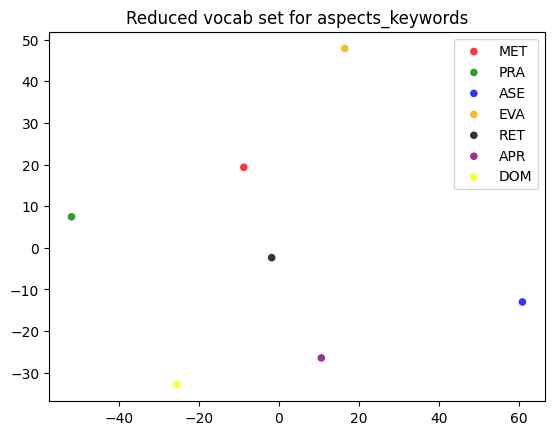

In [60]:
# We can use PCA to reduce the number of dimensions of the vectors
pca = PCA(n_components=2)
# Perform PCA
pca_embeddings = pca.fit_transform(aspects_keywords_vectors)
def two_d_graph(pca_embeddings, title):
    colors = ("red", "green", "blue", "orange", "black", "purple", "yellow")
 
    # Create plot
    fig = plt.figure()
    ax = fig.gca()
 
    for data, color, group in zip(pca_embeddings, colors, aspects[:7]):
        x, y = data
        ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
 
    plt.title(title)
    plt.legend(loc=1)
    plt.show()

two_d_graph(pca_embeddings, 'Reduced vocab set for aspects_keywords')

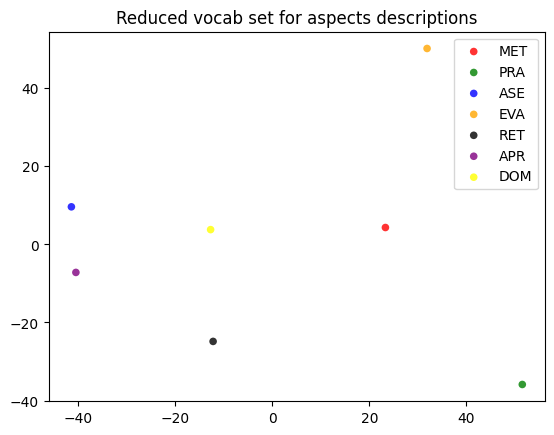

In [61]:
# We will do the same for the aspect descriptions
pca = PCA(n_components=2)
# Perform PCA
pca_embeddings = pca.fit_transform(aspects_description_vectors)
two_d_graph(pca_embeddings, 'Reduced vocab set for aspects descriptions')

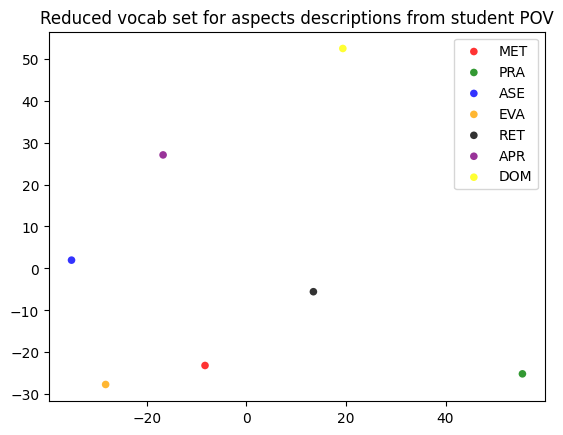

In [62]:
# We will do the same for the aspect students POV descriptions
pca = PCA(n_components=2)
# Perform PCA
pca_embeddings = pca.fit_transform(aspects_studentpov_vectors)
two_d_graph(pca_embeddings, 'Reduced vocab set for aspects descriptions from student POV')

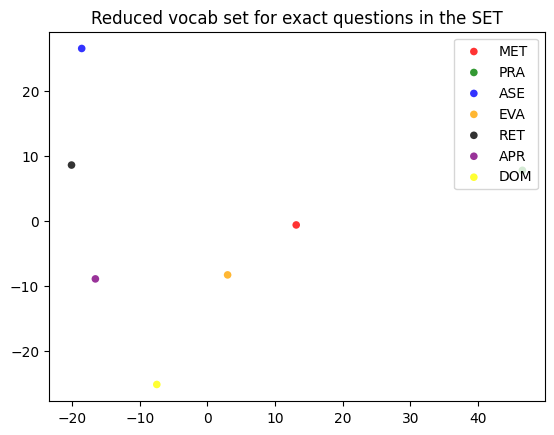

In [63]:
# Finally, we do the same for the aspect exact questions in the SET
pca = PCA(n_components=2)
# Perform PCA
pca_embeddings = pca.fit_transform(aspects_questions_vectors)
two_d_graph(pca_embeddings, 'Reduced vocab set for exact questions in the SET')

In [64]:
# We can now create a comment vector using the word vectors from the Word2Vec model and obtain the most similar words

# Define a function to obtain the comment vector
def get_comment_vector(comment):
    comment_words = comment  # Split the comment into individual words
    comment_vector = np.zeros(model.vector_size)  # Initialize an array of zeros for the comment vector
    
    for word in comment_words:
        if word in model.wv:
            comment_vector += model.wv[word]  # Add the word vector to the comment vector
    
    return comment_vector

# Example usage
comment_vector = get_comment_vector(comments[2])

# Obtain the most similar words to the comment
similar_words = model.wv.similar_by_vector(comment_vector)

print(f"The most similar words to the comment '{comments[2]}' are:")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")


The most similar words to the comment '['sabe', 'muchísimo', 'tema', 'preparada']' are:
acerca: 0.7496934533119202
emociona: 0.7445324063301086
ve: 0.7376204133033752
sabe: 0.733048141002655
transmitirlo: 0.7229672074317932
apasiona: 0.719046950340271
disfruta: 0.7139425277709961
nota: 0.7093999981880188
comunicarlo: 0.6818484663963318
impartirlo: 0.678735077381134


In [65]:
# Save the model
model.save('word2vec.model')

In [66]:
# Load the model
model = Word2Vec.load('word2vec.model')

### 3.3:BERT

In [67]:
df_ecoas.head()

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Tipo Comentario,Comentarios,AVG,Lemm
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,94.428,0.0,0,"Sabe explicar muy bien las cosas teoricas, pe...",0.0,"[saber, explicar, bien, cosa, teorico, hacer, ..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,95.968,0.0,0,Método anticuado de enseñar. Los temas podría...,0.0,"[método, anticuado, enseñar, tema, poder, hace..."
2,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0,96.408,0.0,1,"Sabe muchísimo del tema, muy preparada.",0.0,"[saber, muchísimo, tema, preparado]"
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,94.981,0.0,2,buena maestra si lo recomiendo,1.0,"[buen, maestro, si, recomer]"
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,89.040,0.0,1,Tiene mucho conocimiento sobre los temas.,0.0,"[conocimiento, tema]"


In [68]:
comentarios_merge[:5]

['saber explicar bien cosa teorico hacer falta aterrizar tema practicar mercadotecnia interno poner realizar proyecto mercadotecnia interno empresa tener alguno ejemplo concreto acción poder implementar solo dar teoria basico',
 'método anticuado enseñar tema poder hacer el interesante alumno',
 'saber muchísimo tema preparado',
 'buen maestro si recomer',
 'conocimiento tema']

In [69]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

In [70]:
# This are the questions we will use to compare the comments and obtain the most similar ones
questions = [MET, PRA, ASE, EVA, RET, APR, DOM]


In [71]:
encoded_questions = tokenizer(
    questions,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
)

encoded_responses = tokenizer(
    comentarios_merge,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
)

In [72]:
encoded_questions['input_ids'].shape, encoded_responses['input_ids'].shape

(torch.Size([7, 98]), torch.Size([96540, 128]))

In [73]:
encoded_responses_example = {
    'input_ids': encoded_responses['input_ids'][4],
    'attention_mask': encoded_responses['attention_mask'][4]
}

print(encoded_responses_example)


{'input_ids': tensor([   4, 4764, 2833,    5,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1]), 'attention_mask': tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0

## 4:Topic Recognizion

To continue with this task, we will use the last text representation of the previous section: BERT.

We perfomed cosine similarity between the encoded questions and the encoded comments, this give us an idea of the aspects that the students are talking about in the comment.

In [74]:
# Determine the maximum sequence length for questions and answers
max_sequence_length = max(len(encoded_questions['input_ids'][0]), len(encoded_responses['input_ids'][0]))

# Initialize an empty array to store similarity scores
similarity_scores = np.zeros((len(questions), len(comentarios_merge)))

# Calculate cosine similarity for each question-answer pair
for i, question_embedding in enumerate(encoded_questions['input_ids']):
    for j, answer_embedding in enumerate(encoded_responses['input_ids']):
        # Pad the shorter sequence to match the maximum length
        padded_question = np.pad(question_embedding.numpy(), (0, max_sequence_length - len(question_embedding)), 'constant')
        padded_answer = np.pad(answer_embedding.numpy(), (0, max_sequence_length - len(answer_embedding)), 'constant')

        # Calculate cosine similarity between the padded embeddings
        similarity = cosine_similarity([padded_question], [padded_answer])[0][0]
        similarity_scores[i][j] = similarity


In [75]:
# We have the scores for similarity between comment and questions, 6 aspects for 98427 different comments
similarity_scores.shape

(7, 96540)

In [76]:
similarity_scores.T

array([[0.29244624, 0.16194861, 0.39008889, ..., 0.27604676, 0.33455727,
        0.33415944],
       [0.18810163, 0.17589556, 0.33831498, ..., 0.12698345, 0.11523952,
        0.13322027],
       [0.14040695, 0.22535621, 0.17936546, ..., 0.06912226, 0.13793524,
        0.1109859 ],
       ...,
       [0.2359397 , 0.34211442, 0.16170022, ..., 0.29682772, 0.24438209,
        0.14677348],
       [0.14788696, 0.2552753 , 0.21707712, ..., 0.24342718, 0.34202794,
        0.10616454],
       [0.14792842, 0.26615402, 0.32147522, ..., 0.21160008, 0.28882601,
        0.15747003]])

In [102]:
most_likely_questions = np.argmax(similarity_scores.T, axis=1) # Find the index of the max value along the rows
mlikely_question = pd.DataFrame(most_likely_questions) # Convert to dataframe
questions_counts = mlikely_question.value_counts() # Count the number of times each question was the most similar

List_questions = []
for idx in range(len(questions)):
    List_questions.append([questions[idx], aspects[idx], questions_counts[idx]])

pd.set_option('colheader_justify', 'center') # Center the column's names

df_countQA = pd.DataFrame(List_questions, columns = ['Pregunta', 'Aspect Key', 'Count'])
print(df_countQA)

                       Pregunta                      Aspect Key  Count
0  La metodología y actividades de aprendizaje so...     APR      8212
1  La comprensión de conceptos a través de su apl...     ASE      9570
2  La interacción efectiva con el profesor y la a...     DOM     36157
3  El sistema de evaluación juega un papel crucia...     EVA      4497
4  El nivel de reto intelectual es vital para est...     MEJ      1091
5  El papel del educador como guía del aprendizaj...     MET     35657
6  El dominio de la materia por parte del profeso...     PRA      1356


In [78]:
mlikely_question.rename(columns={0: "Cosine_Sim_MostLikeQ"}, inplace=True)
mlikely_question['MostLikeAsp'] = [aspects[i] for i in mlikely_question['Cosine_Sim_MostLikeQ']]

In [79]:
aspects[:7]

['MET', 'PRA', 'ASE', 'EVA', 'RET', 'APR', 'DOM']

In [80]:
similarity_scores.T[0]

array([0.29244624, 0.16194861, 0.39008889, 0.41674129, 0.27604676,
       0.33455727, 0.33415944])

In [81]:
df_ecoas['mlq_numb'] = mlikely_question['Cosine_Sim_MostLikeQ'] # Add the most likely question number to the dataframe
df_ecoas['mlq_asp'] = mlikely_question['MostLikeAsp'] # Add the most likely question KEY to the dataframe
df_ecoas.head()

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Tipo Comentario,Comentarios,AVG,Lemm,mlq_numb,mlq_asp
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,94.428,0.0,0,"Sabe explicar muy bien las cosas teoricas, pe...",0.0,"[saber, explicar, bien, cosa, teorico, hacer, ...",3,EVA
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,95.968,0.0,0,Método anticuado de enseñar. Los temas podría...,0.0,"[método, anticuado, enseñar, tema, poder, hace...",2,ASE
2,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0,96.408,0.0,1,"Sabe muchísimo del tema, muy preparada.",0.0,"[saber, muchísimo, tema, preparado]",1,PRA
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,94.981,0.0,2,buena maestra si lo recomiendo,1.0,"[buen, maestro, si, recomer]",1,PRA
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,89.040,0.0,1,Tiene mucho conocimiento sobre los temas.,0.0,"[conocimiento, tema]",2,ASE


In [82]:
df_ecoas.tail()

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Tipo Comentario,Comentarios,AVG,Lemm,mlq_numb,mlq_asp
96535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,94.288,1.0,2,"Sabe mucho de la materia y le gusta enseñar, n...",0.0,"[saber, materia, gustar, enseñar, no, ir, pris...",3,EVA
96536,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,80.660,1.0,2,excelente profesor lo recomiendo ampliamente,1.0,"[excelente, profesor, recomer, ampliamente]",5,APR
96537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,89.843,1.0,2,"El profesor llegó a salvar el semestre, las po...",0.0,"[profesor, llegar, salvar, semestre, poco, cla...",3,EVA
96538,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,92.559,1.0,1,"Dominio del tema, excelente profesor, enseña d...",1.0,"[dominio, tema, excelente, profesor, enseñar, ...",5,APR
96539,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0,93.150,1.0,1,Que triste que solo me pudo dar 3 clases. Falt...,1.0,"[triste, solo, poder, dar, 3, clase, falto, ti...",2,ASE


Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation (LDA) is a type of statistical model that is used to discover the abstract "topics" that occur in a collection of documents. It's widely used in natural language processing (NLP) for tasks like document classification, organizing large sets of documents, and helping in understanding the main themes (educational aspects in this case) in them.

In [83]:
commentsL[:5]

0    [saber, explicar, bien, cosa, teorico, hacer, ...
1    [método, anticuado, enseñar, tema, poder, hace...
2                  [saber, muchísimo, tema, preparado]
3                         [buen, maestro, si, recomer]
4                                 [conocimiento, tema]
Name: Lemm, dtype: object

In [84]:
# Create dictionary and document-term matrix
dictionary = corpora.Dictionary(commentsL)
corpus = [dictionary.doc2bow(doc) for doc in commentsL]

In [85]:
# Build LDA model
num_topics = 8
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Print topics and their top keywords
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')

# Get topics for each document
topics_for_documents = [lda_model[doc] for doc in corpus]

Topic: 0 
Words: 0.092*"no" + 0.056*"clase" + 0.022*"hacer" + 0.021*"poder" + 0.017*"dar" + 0.015*"vez" + 0.015*"él" + 0.014*"ser" + 0.013*"tiempo" + 0.013*"solo"

Topic: 1 
Words: 0.055*"siempre" + 0.054*"conocimiento" + 0.054*"duda" + 0.049*"tema" + 0.036*"materia" + 0.029*"profesor" + 0.028*"recomer" + 0.028*"resolver" + 0.026*"gran" + 0.025*"si"

Topic: 2 
Words: 0.260*"buen" + 0.133*"excelente" + 0.126*"maestro" + 0.106*"profesor" + 0.024*"profesora" + 0.011*"persona" + 0.009*"super" + 0.008*"actitud" + 0.007*"the" + 0.006*"preparado"

Topic: 3 
Words: 0.146*"no" + 0.098*"recomendar" + 0.066*"buen" + 0.066*"si" + 0.057*"claro" + 0.054*"explicación" + 0.017*"quedar" + 0.017*"evaluación" + 0.017*"razón" + 0.016*"él"

Topic: 4 
Words: 0.047*"mejor" + 0.044*"alumno" + 0.042*"profesor" + 0.041*"aprender" + 0.025*"maestro" + 0.019*"materia" + 0.015*"aprendizaje" + 0.015*"tener" + 0.014*"preocupar" + 0.013*"ser"

Topic: 5 
Words: 0.149*"explicar" + 0.121*"bien" + 0.086*"tema" + 0.045*"sa

In [86]:
# Define the number of topics
num_topics = 8

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(commentsL)

# Filter out tokens that appear in less than 10 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=10, no_above=0.5)

# Convert the documents into a bag-of-words format: list of (token_id, token_count) tuples
corpus = [dictionary.doc2bow(doc) for doc in commentsL]

# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# Print the top keywords for each topic
for topic_id in range(num_topics):
    top_words = lda_model.show_topic(topic_id, topn=10)
    print(f"Topic {topic_id + 1}:")
    print([word[0] for word in top_words])

# Compute coherence score to evaluate the model
coherence_model_lda = CoherenceModel(model=lda_model, texts=commentsL, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)

topics_for_documents = [lda_model[doc] for doc in corpus]

Topic 1:
['explicar', 'bien', 'explicación', 'demasiado', 'fácil', 'volver', 'enseñanza', 'información', 'importante', 'evaluar']
Topic 2:
['persona', 'semestre', 'comprender', 'ayuda', 'aburrido', 'mismo', 'grupo', 'atención', 'considerar', 'diferente']
Topic 3:
['tema', 'buen', 'saber', 'maestro', 'alumno', 'si', 'él', 'enseñar', 'recomendar', 'entender']
Topic 4:
['interesante', 'concepto', 'llevar', 'decir', 'tedioso', 'práctico', 'actitud', 'final', 'el', 'perder']
Topic 5:
['siempre', 'mejor', 'ayudar', 'todo', 'dominar', 'parecer', 'hora', 'tú', 'buscar', 'dispuesto']
Topic 6:
['profesor', 'excelente', 'aprender', 'nunca', 'interesar', 'difícil', 'evaluación', 'mal', 'divertido', 'trabajar']
Topic 7:
['materia', 'conocimiento', 'ser', 'experiencia', 'gran', 'cada', 'embargo', 'necesitar', 'calificación', 'calificar']
Topic 8:
['clase', 'no', 'hacer', 'dar', 'mucho', 'poder', 'vez', 'manera', 'duda', 'ver']


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Coherence Score: 0.5396679415051697


In [87]:
len(topics_for_documents)

96540

In [88]:
commentsL[2]

['saber', 'muchísimo', 'tema', 'preparado']

In [89]:
topics_for_documents[0]

([(0, 0.08475492),
  (1, 0.03248213),
  (2, 0.16973849),
  (3, 0.06106166),
  (4, 0.040244337),
  (5, 0.03985995),
  (6, 0.06058521),
  (7, 0.5112734)],
 [(0, [3]),
  (1, [7]),
  (2, [7]),
  (3, [0]),
  (4, [0]),
  (5, [7]),
  (6, [7]),
  (7, [7]),
  (8, [7]),
  (9, [7]),
  (10, [0]),
  (11, [7]),
  (12, [7]),
  (13, [7]),
  (14, [3, 6, 7, 1, 4, 2]),
  (15, [7]),
  (16, [7]),
  (17, [7]),
  (18, [7]),
  (19, [7]),
  (20, [7]),
  (21, [2]),
  (22, [7]),
  (23, [2]),
  (24, [7]),
  (25, [7]),
  (26, [7])],
 [(0, [(3, 0.99620944)]),
  (1, [(7, 0.9999128)]),
  (2, [(7, 0.9996233)]),
  (3, [(0, 0.9986586)]),
  (4, [(0, 0.9999922)]),
  (5, [(7, 0.99973106)]),
  (6, [(7, 0.99997973)]),
  (7, [(7, 0.99999297)]),
  (8, [(7, 0.99997276)]),
  (9, [(7, 0.99980503)]),
  (10, [(0, 0.9999938)]),
  (11, [(7, 0.99997497)]),
  (12, [(7, 0.9999943)]),
  (13, [(7, 0.99929404)]),
  (14,
   [(1, 0.09134803),
    (2, 0.018702624),
    (3, 0.8386599),
    (4, 0.025585024),
    (6, 0.78517306),
    (7, 0.11093

LDA hyper-parameters fine tuning:

Use different number of values of filter extremes and observe the performance on coherence score for different number of topics

In [90]:
# Define a range of no_below filter extreme values
below1 = 100
below2 = 1000
below3 = 2500
below4 = 0

#Define a range of no_above filter extreme values
above1 = 0.7
above2 = 0.65
above3 = 0.6
above4 = 1

extreme_values = [[below1, above1],[below2, above2],[below3, above3], [below4, above4]]

# Define a range of candidate numbers of topics
min_topics = 2
max_topics = 10
step_size = 1
topic_range = range(min_topics, max_topics + 1, step_size)

In [91]:
dictionary = corpora.Dictionary(commentsL)
print(len(dictionary))

17837


In [92]:
for extremes in extreme_values:
    print('- - - - - - - - - - - - - - - - - - - - - - - ')
    coherence_scores = []
    for num_topics in topic_range:
        print(f'Number of topics: {num_topics} Extremes: {extremes}')
        # Create a dictionary representation of the documents.
        dictionary = corpora.Dictionary(commentsL)

        # Filter out tokens that appear in less than 10 documents or more than 50% of the documents
        dictionary.filter_extremes(no_below=extremes[0], no_above=extremes[1])
        dictionary.compactify()
        print(len(dictionary))

        # Convert the documents into a bag-of-words format: list of (token_id, token_count) tuples
        corpus = [dictionary.doc2bow(doc) for doc in commentsL]

- - - - - - - - - - - - - - - - - - - - - - - 
Number of topics: 2 Extremes: [100, 0.7]
887
Number of topics: 3 Extremes: [100, 0.7]
887
Number of topics: 4 Extremes: [100, 0.7]
887
Number of topics: 5 Extremes: [100, 0.7]
887
Number of topics: 6 Extremes: [100, 0.7]
887
Number of topics: 7 Extremes: [100, 0.7]
887
Number of topics: 8 Extremes: [100, 0.7]
887
Number of topics: 9 Extremes: [100, 0.7]
887
Number of topics: 10 Extremes: [100, 0.7]
887
- - - - - - - - - - - - - - - - - - - - - - - 
Number of topics: 2 Extremes: [1000, 0.65]
172
Number of topics: 3 Extremes: [1000, 0.65]
172
Number of topics: 4 Extremes: [1000, 0.65]
172
Number of topics: 5 Extremes: [1000, 0.65]
172
Number of topics: 6 Extremes: [1000, 0.65]
172
Number of topics: 7 Extremes: [1000, 0.65]
172
Number of topics: 8 Extremes: [1000, 0.65]
172
Number of topics: 9 Extremes: [1000, 0.65]
172
Number of topics: 10 Extremes: [1000, 0.65]
172
- - - - - - - - - - - - - - - - - - - - - - - 
Number of topics: 2 Extremes:

- - - - - - - - - - - - - - - - - - - - - - - 
Len of the Dictionary: 887
Number of topics: 2 Extremes: [100, 0.7]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 3 Extremes: [100, 0.7]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 4 Extremes: [100, 0.7]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 5 Extremes: [100, 0.7]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 6 Extremes: [100, 0.7]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 7 Extremes: [100, 0.7]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 8 Extremes: [100, 0.7]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 9 Extremes: [100, 0.7]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 10 Extremes: [100, 0.7]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

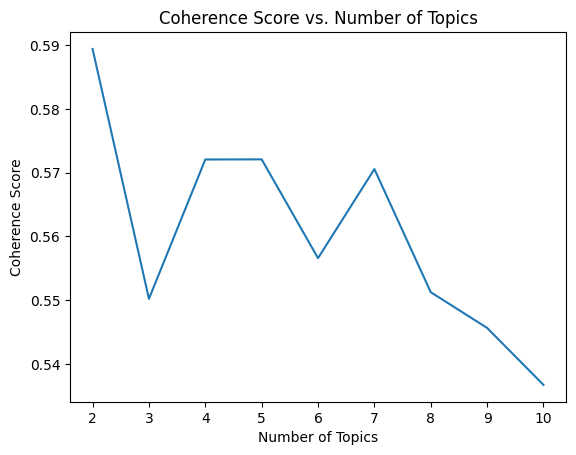

- - - - - - - - - - - - - - - - - - - - - - - 
Len of the Dictionary: 172
Number of topics: 2 Extremes: [1000, 0.65]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 3 Extremes: [1000, 0.65]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 4 Extremes: [1000, 0.65]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 5 Extremes: [1000, 0.65]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 6 Extremes: [1000, 0.65]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 7 Extremes: [1000, 0.65]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 8 Extremes: [1000, 0.65]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 9 Extremes: [1000, 0.65]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 10 Extremes: [1000, 0.65]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

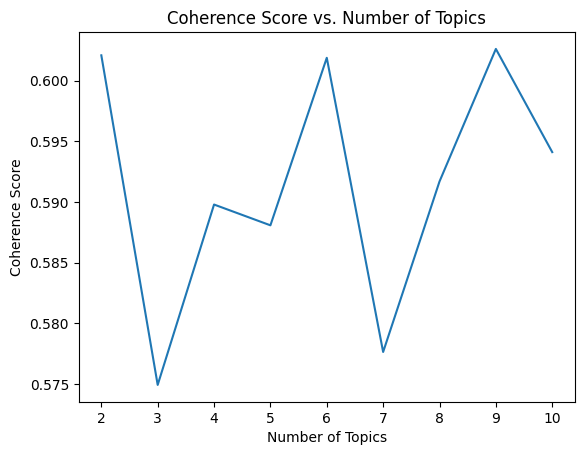

- - - - - - - - - - - - - - - - - - - - - - - 
Len of the Dictionary: 63
Number of topics: 2 Extremes: [2500, 0.6]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 3 Extremes: [2500, 0.6]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 4 Extremes: [2500, 0.6]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 5 Extremes: [2500, 0.6]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 6 Extremes: [2500, 0.6]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 7 Extremes: [2500, 0.6]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 8 Extremes: [2500, 0.6]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 9 Extremes: [2500, 0.6]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 10 Extremes: [2500, 0.6]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

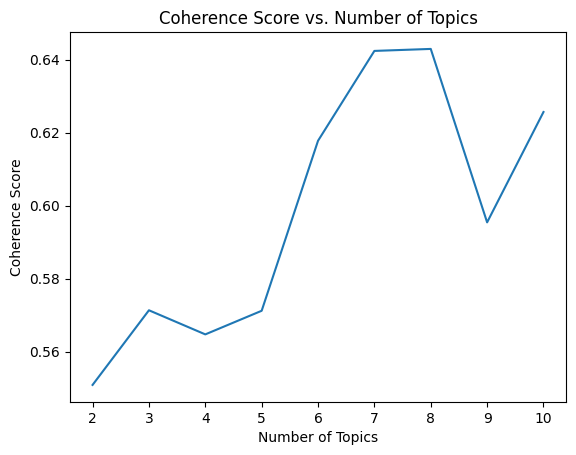

- - - - - - - - - - - - - - - - - - - - - - - 
Len of the Dictionary: 17837
Number of topics: 2 Extremes: [0, 1]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 3 Extremes: [0, 1]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 4 Extremes: [0, 1]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 5 Extremes: [0, 1]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 6 Extremes: [0, 1]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 7 Extremes: [0, 1]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 8 Extremes: [0, 1]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 9 Extremes: [0, 1]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Number of topics: 10 Extremes: [0, 1]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

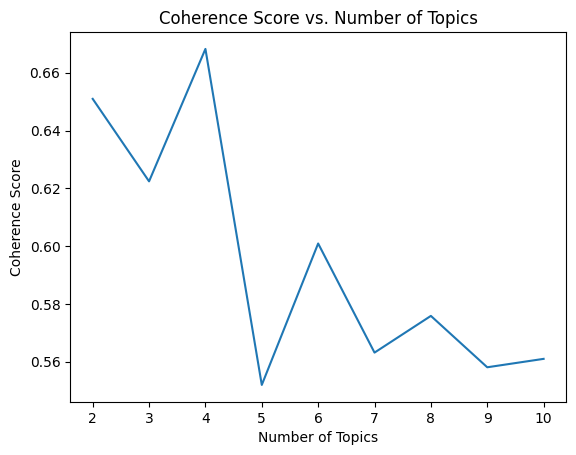

In [93]:
for extremes in extreme_values:
    print('- - - - - - - - - - - - - - - - - - - - - - - ')
    coherence_scores = []

    # Create a dictionary representation of the documents.
    dictionary = corpora.Dictionary(commentsL)

    # Filter out tokens that appear in less than 10 documents or more than 50% of the documents
    dictionary.filter_extremes(no_below=extremes[0], no_above=extremes[1])
    dictionary.compactify()
    print(f'Len of the Dictionary: {len(dictionary)}')

    # Convert the documents into a bag-of-words format: list of (token_id, token_count) tuples
    corpus = [dictionary.doc2bow(doc) for doc in commentsL]

    for num_topics in topic_range:
        print(f'Number of topics: {num_topics} Extremes: {extremes}')


        # Train the LDA model
        lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)

        coherence_model_lda = CoherenceModel(model=lda_model, texts=commentsL, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherence_model_lda.get_coherence())

    # Plot the coherence scores
    plt.plot(topic_range, coherence_scores)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Score vs. Number of Topics")
    plt.show()

I try the best number of topics that resulted from the experiments

In [94]:
# Define the number of topics
num_topics = 2

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(commentsL)

# Filter out tokens that appear in less than 10 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=100, no_above=0.7)

# Convert the documents into a bag-of-words format: list of (token_id, token_count) tuples
corpus = [dictionary.doc2bow(doc) for doc in commentsL]

# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=30,
                     alpha='auto',
                     per_word_topics=True)

# Print the top keywords for each topic
for topic_id in range(num_topics):
    top_words = lda_model.show_topic(topic_id, topn=10)
    print(f"Topic {topic_id + 1}:")
    print([word[0] for word in top_words])

# Compute coherence score to evaluate the model
coherence_model_lda = CoherenceModel(model=lda_model, texts=commentsL, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)

topics_for_documents = [lda_model[doc] for doc in corpus]

Topic 1:
['tema', 'buen', 'profesor', 'explicar', 'saber', 'materia', 'bien', 'maestro', 'conocimiento', 'excelente']
Topic 2:
['clase', 'no', 'hacer', 'dar', 'él', 'poder', 'ser', 'vez', 'ver', 'aprender']


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Coherence Score: 0.5975816117142956


In [95]:
# Altough the coherence score is working properly, the coherence score is not roust enough to determine the presene of topics
# We will stick with the BERT cosine similarity to determine the most likely topic for each comment instead
topics_for_documents[2]

([(0, 0.76613414), (1, 0.23386589)],
 [(17, [0]), (19, [0]), (27, [0]), (28, [0])],
 [(17, [(0, 0.99796504)]),
  (19, [(0, 0.99998677)]),
  (27, [(0, 0.9998808)]),
  (28, [(0, 0.9997906)])])

## 5: ML Classifiers

In [15]:
df_ecoas.head()

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Tipo Comentario,Comentarios,AVG,Lemm
0,5.0,4.0,9.0,0.0,5.0,10.0,4.0,10.0,8.0,0,94.428,0.0,0,"Sabe explicar muy bien las cosas teoricas, pe...",7.2,"[saber, explicar, bien, cosa, teorico, hacer, ..."
1,5.0,8.0,8.0,0.0,5.0,7.0,8.0,5.0,8.0,0,95.968,0.0,0,Método anticuado de enseñar. Los temas podría...,6.3,"[método, anticuado, enseñar, tema, poder, hace..."
2,10.0,10.0,5.0,1.0,8.0,10.0,10.0,10.0,8.0,0,96.408,0.0,1,"Sabe muchísimo del tema, muy preparada.",8.8,"[saber, muchísimo, tema, preparado]"
3,10.0,10.0,10.0,1.0,10.0,10.0,10.0,10.0,10.0,0,94.981,0.0,2,buena maestra si lo recomiendo,10.0,"[buen, maestro, si, recomer]"
4,9.0,10.0,9.0,1.0,9.0,9.0,9.0,9.0,9.0,0,89.040,0.0,1,Tiene mucho conocimiento sobre los temas.,9.0,"[conocimiento, tema]"


### 5.1: Using TF-IDF

In [16]:
aspects

['MET', 'PRA', 'ASE', 'EVA', 'RET', 'APR', 'DOM', 'REC', 'MEJ']

In [22]:
aspects_classes = df_ecoas.drop(columns=['GÉNERO ALUMNO', 'PROM ACUMULADO EN PROFESIONAL', 'Género del profesor', 'Tipo Comentario', 'Comentarios', 'AVG','Lemm','mlq_numb', 'mlq_asp'], errors='ignore')
aspects_classes.head()

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE
0,5.0,4.0,9.0,0.0,5.0,10.0,4.0,10.0,8.0
1,5.0,8.0,8.0,0.0,5.0,7.0,8.0,5.0,8.0
2,10.0,10.0,5.0,1.0,8.0,10.0,10.0,10.0,8.0
3,10.0,10.0,10.0,1.0,10.0,10.0,10.0,10.0,10.0
4,9.0,10.0,9.0,1.0,9.0,9.0,9.0,9.0,9.0


In [17]:
comentarios_merge[:5]

['saber explicar bien cosa teorico hacer falta aterrizar tema practicar mercadotecnia interno poner realizar proyecto mercadotecnia interno empresa tener alguno ejemplo concreto acción poder implementar solo dar teoria basico',
 'método anticuado enseñar tema poder hacer el interesante alumno',
 'saber muchísimo tema preparado',
 'buen maestro si recomer',
 'conocimiento tema']

In [18]:
comments_train,comments_test,aspects_train, aspects_test = train_test_split(comentarios_merge, aspects_classes, test_size=0.25, random_state=30)
print('Train:', 'Comentarios->', len(comments_train), 'Aspectos->',  aspects_train.shape, '\nTest:', 'Comentarios->', len(comments_test),'Aspectos->', aspects_test.shape)

Train: Comentarios-> 72405 Aspectos-> (72405, 9) 
Test: Comentarios-> 24135 Aspectos-> (24135, 9)


In [19]:
vectorizer = TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(comments_train)
tf_x_test = vectorizer.transform(comments_test)

#### Decision Tree

In [112]:
# Decision Tree
classN = ['Negative', 'Positive']
accList = []
baccList= []
aucList = []
cmatrixList = []
creportList = []

for asp in aspects:
  t = DecisionTreeClassifier(random_state = 1509654,criterion='entropy',max_depth=8)
  t.fit(tf_x_train, aspects_train[asp])

  # Metrics
  y_pred = t.predict(tf_x_test)

  accList.append(t.score(tf_x_test, aspects_test[asp]))
  baccList.append(metrics.balanced_accuracy_score(aspects_test[asp], y_pred))
  cmatrixList.append(metrics.confusion_matrix(aspects_test[asp], y_pred))
  creportList.append(metrics.classification_report(aspects_test[asp], y_pred))

for a in range(len(aspects)):
  print('------------',aspects[a],'------------')
  # print('Accuracy: ', round(accList[a],2))
  print('Balanced Acc: ', round(baccList[a],2))
  # print('Auc: ', round(aucList[a],2))
  # print('Confusion Matrix: \n', cmatrixList[a])
  print(creportList[a])

------------ APR ------------
Balanced Acc:  0.65
              precision    recall  f1-score   support

         0.0       0.67      0.41      0.51      8841
         1.0       0.72      0.88      0.80     15294

    accuracy                           0.71     24135
   macro avg       0.70      0.65      0.65     24135
weighted avg       0.70      0.71      0.69     24135

------------ ASE ------------
Balanced Acc:  0.62
              precision    recall  f1-score   support

         0.0       0.61      0.35      0.44      7698
         1.0       0.75      0.90      0.81     16437

    accuracy                           0.72     24135
   macro avg       0.68      0.62      0.63     24135
weighted avg       0.70      0.72      0.69     24135

------------ DOM ------------
Balanced Acc:  0.55
              precision    recall  f1-score   support

         0.0       0.60      0.13      0.21      5070
         1.0       0.81      0.98      0.88     19065

    accuracy                    

#### Random Forest

In [113]:
# Random Forest
classN = ['Negative', 'Positive']
accList = []
baccList= []
aucList = []
cmatrixList = []
creportList = []

for asp in aspects:
  t = RandomForestClassifier(min_samples_leaf=8)
  t.fit(tf_x_train, aspects_train[asp])

  # Metrics
  y_pred = t.predict(tf_x_test)

  accList.append(t.score(tf_x_test, aspects_test[asp]))
  baccList.append(metrics.balanced_accuracy_score(aspects_test[asp], y_pred))
  cmatrixList.append(metrics.confusion_matrix(aspects_test[asp], y_pred))
  creportList.append(metrics.classification_report(aspects_test[asp], y_pred))

for a in range(len(aspects)):
  print('------------',aspects[a],'------------')
  # print('Accuracy: ', round(accList[a],2))
  print('Balanced Acc: ', round(baccList[a],2))
  # print('Auc: ', round(aucList[a],2))
  # print('Confusion Matrix: \n', cmatrixList[a])
  print(creportList[a])

------------ APR ------------
Balanced Acc:  0.66
              precision    recall  f1-score   support

         0.0       0.75      0.41      0.53      8841
         1.0       0.73      0.92      0.81     15294

    accuracy                           0.73     24135
   macro avg       0.74      0.66      0.67     24135
weighted avg       0.74      0.73      0.71     24135

------------ ASE ------------
Balanced Acc:  0.59
              precision    recall  f1-score   support

         0.0       0.76      0.22      0.34      7698
         1.0       0.72      0.97      0.83     16437

    accuracy                           0.73     24135
   macro avg       0.74      0.59      0.58     24135
weighted avg       0.73      0.73      0.67     24135

------------ DOM ------------
Balanced Acc:  0.51
              precision    recall  f1-score   support

         0.0       0.89      0.01      0.02      5070
         1.0       0.79      1.00      0.88     19065

    accuracy                    

#### SVM

In [21]:
for asp in aspects:
    print(aspects_train[asp])

48734    10.0
36669    10.0
74941     0.0
14345    10.0
55199    10.0
         ... 
66455    10.0
46220     9.0
48045     4.0
70053    10.0
38693    10.0
Name: MET, Length: 72405, dtype: float64
48734    10.0
36669    10.0
74941     0.0
14345    10.0
55199    10.0
         ... 
66455    10.0
46220     9.0
48045     1.0
70053    10.0
38693    10.0
Name: PRA, Length: 72405, dtype: float64
48734    10.0
36669    10.0
74941     0.0
14345    10.0
55199    10.0
         ... 
66455    10.0
46220    10.0
48045     6.0
70053    10.0
38693    10.0
Name: ASE, Length: 72405, dtype: float64
48734    10.0
36669    10.0
74941     0.0
14345    10.0
55199    10.0
         ... 
66455    10.0
46220     9.0
48045     0.0
70053    10.0
38693    10.0
Name: EVA, Length: 72405, dtype: float64
48734    10.0
36669    10.0
74941     0.0
14345    10.0
55199    10.0
         ... 
66455    10.0
46220     9.0
48045     2.0
70053    10.0
38693    10.0
Name: RET, Length: 72405, dtype: float64
48734    10.0
36669    10

In [20]:
# SVM linear
classN = ['Negative', 'Positive']
accList = []
baccList= []
aucList = []
cmatrixList = []
creportList = []

for asp in aspects:
  svm = SVC(kernel='linear', random_state=12022024)
  svm.fit(tf_x_train, aspects_train[asp])

  # Metrics
  y_pred = svm.predict(tf_x_test)

  accList.append(svm.score(tf_x_test, aspects_test[asp]))
  baccList.append(metrics.balanced_accuracy_score(aspects_test[asp], y_pred))
  cmatrixList.append(metrics.confusion_matrix(aspects_test[asp], y_pred))
  creportList.append(metrics.classification_report(aspects_test[asp], y_pred))

for a in range(len(aspects)):
  print('------------',aspects[a],'------------')
  # print('Accuracy: ', round(accList[a],2))
  print('Balanced Acc: ', round(baccList[a],2))
  # print('Auc: ', round(aucList[a],2))
  # print('Confusion Matrix: \n', cmatrixList[a])
  print(creportList[a])

/Users/diegoacosta/Documents/Maestría/Thesis/Notebooks/Complete/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/diegoacosta/Documents/Maestría/Thesis/Notebooks/Complete/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/diegoacosta/Documents/Maestría/Thesis/Notebooks/Complete/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U

------------ MET ------------
Balanced Acc:  0.13
              precision    recall  f1-score   support

         0.0       0.32      0.34      0.33       290
         1.0       0.00      0.00      0.00       132
         2.0       0.00      0.00      0.00       188
         3.0       0.14      0.00      0.01       236
         4.0       0.00      0.00      0.00       289
         5.0       0.13      0.00      0.01       575
         6.0       0.17      0.01      0.01       757
         7.0       0.17      0.02      0.03      1442
         8.0       0.21      0.07      0.10      2748
         9.0       0.24      0.01      0.02      4191
        10.0       0.58      0.99      0.73     13287

    accuracy                           0.56     24135
   macro avg       0.18      0.13      0.11     24135
weighted avg       0.41      0.56      0.42     24135

------------ PRA ------------
Balanced Acc:  0.12
              precision    recall  f1-score   support

         0.0       0.37      0.2

In [1]:
# SVM poly
classN = ['Negative', 'Positive']
accList = []
baccList= []
aucList = []
cmatrixList = []
creportList = []

for asp in aspects:
  svm = SVC(kernel='poly', random_state=12022024)
  svm.fit(tf_x_train, aspects_train[asp])

  # Metrics
  y_pred = svm.predict(tf_x_test)

  accList.append(svm.score(tf_x_test, aspects_test[asp]))
  baccList.append(metrics.balanced_accuracy_score(aspects_test[asp], y_pred))
  cmatrixList.append(metrics.confusion_matrix(aspects_test[asp], y_pred))
  creportList.append(metrics.classification_report(aspects_test[asp], y_pred))

for a in range(len(aspects)):
  print('------------',aspects[a],'------------')
  # print('Accuracy: ', round(accList[a],2))
  print('Balanced Acc: ', round(baccList[a],2))
  # print('Auc: ', round(aucList[a],2))
  # print('Confusion Matrix: \n', cmatrixList[a])
  print(creportList[a])

NameError: name 'SVC' is not defined

In [ ]:
# SVM rbf
classN = ['Negative', 'Positive']
accList = []
baccList= []
aucList = []
cmatrixList = []
creportList = []

for asp in aspects:
  svm = SVC(kernel='rbf', random_state=12022024)
  svm.fit(tf_x_train, aspects_train[asp])

  # Metrics
  y_pred = svm.predict(tf_x_test)

  accList.append(svm.score(tf_x_test, aspects_test[asp]))
  baccList.append(metrics.balanced_accuracy_score(aspects_test[asp], y_pred))
  cmatrixList.append(metrics.confusion_matrix(aspects_test[asp], y_pred))
  creportList.append(metrics.classification_report(aspects_test[asp], y_pred))

for a in range(len(aspects)):
  print('------------',aspects[a],'------------')
  # print('Accuracy: ', round(accList[a],2))
  print('Balanced Acc: ', round(baccList[a],2))
  # print('Auc: ', round(aucList[a],2))
  # print('Confusion Matrix: \n', cmatrixList[a])
  print(creportList[a])

In [ ]:
# SVM sigmoid
classN = ['Negative', 'Positive']
accList = []
baccList= []
aucList = []
cmatrixList = []
creportList = []

for asp in aspects:
  svm = SVC(kernel='sigmoid', random_state=12022024)
  svm.fit(tf_x_train, aspects_train[asp])

  # Metrics
  y_pred = svm.predict(tf_x_test)

  accList.append(svm.score(tf_x_test, aspects_test[asp]))
  baccList.append(metrics.balanced_accuracy_score(aspects_test[asp], y_pred))
  cmatrixList.append(metrics.confusion_matrix(aspects_test[asp], y_pred))
  creportList.append(metrics.classification_report(aspects_test[asp], y_pred))

for a in range(len(aspects)):
  print('------------',aspects[a],'------------')
  # print('Accuracy: ', round(accList[a],2))
  print('Balanced Acc: ', round(baccList[a],2))
  # print('Auc: ', round(aucList[a],2))
  # print('Confusion Matrix: \n', cmatrixList[a])
  print(creportList[a])

#### Naive-Bayes

In [ ]:
# Naive Bayes
aspects_test = ['REC', 'MEJ']
classN = ['Negative', 'Positive']
accList = []
baccList= []
aucList = []
cmatrixList = []
creportList = []

for asp in aspects:
  mnb = MultinomialNB()
  mnb.fit(tf_x_train, aspects_train[asp])

  # Metrics
  y_pred = mnb.predict(tf_x_test)

  accList.append(mnb.score(tf_x_test, aspects_test[asp]))
  baccList.append(metrics.balanced_accuracy_score(aspects_test[asp], y_pred))
  cmatrixList.append(metrics.confusion_matrix(aspects_test[asp], y_pred))
  creportList.append(metrics.classification_report(aspects_test[asp], y_pred))

for a in range(len(aspects)):
  print('------------',aspects[a],'------------')
  # print('Accuracy: ', round(accList[a],2))
  print('Balanced Acc: ', round(baccList[a],2))
  # print('Auc: ', round(aucList[a],2))
  # print('Confusion Matrix: \n', cmatrixList[a])
  print(creportList[a])

### 5.2: Using Word Embeddings

In [ ]:
# Load the model
model = Word2Vec.load('word2vec.model')

# Define a function to obtain the comment vector
def get_comments_vectors(comments):
    comments_vectors = []
    for comment in comments:
        comment_words = comment  # Split the comment into individual words
        comment_vector = np.zeros(model.vector_size)  # Initialize an array of zeros for the comment vector
        
        for word in comment_words:
            if word in model.wv:
                comment_vector += model.wv[word]  # Add the word vector to the comment vector
        comments_vectors.append(comment_vector)
    return comments_vectors

# Example usage
comments_vectors = get_comments_vectors(comments)

In [ ]:
print(comments_vectors[0])
print(len(comments_vectors))

In [ ]:
comments_train,comments_test,aspects_train, aspects_test = train_test_split(comments_vectors, aspects_classes, test_size=0.25, random_state=30)
print('Train:', 'Comentarios->', len(comments_train), 'Aspectos->',  aspects_train.shape, '\nTest:', 'Comentarios->', len(comments_test),'Aspectos->', aspects_test.shape)

## 6: DL Classifiers

### 6.1 Using Word Embeddings

In [ ]:
# SVM poly
aspects_test = ['REC', 'APR']
classN = ['Negative', 'Positive']
accList = []
baccList= []
aucList = []
cmatrixList = []
creportList = []

for asp in aspects_test:
  svm = SVC(kernel='poly', random_state=12022024)
  svm.fit(comments_vectors, aspects_train[asp])

  # Metrics
  y_pred = svm.predict(tf_x_test)

  accList.append(svm.score(tf_x_test, aspects_test[asp]))
  baccList.append(metrics.balanced_accuracy_score(aspects_test[asp], y_pred))
  cmatrixList.append(metrics.confusion_matrix(aspects_test[asp], y_pred))
  creportList.append(metrics.classification_report(aspects_test[asp], y_pred))

for a in range(len(aspects_test)):
  print('------------',aspects_test[a],'------------')
  # print('Accuracy: ', round(accList[a],2))
  print('Balanced Acc: ', round(baccList[a],2))
  # print('Auc: ', round(aucList[a],2))
  # print('Confusion Matrix: \n', cmatrixList[a])
  print(creportList[a])

#### Multilayer perceptron

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
aspectos = ['APR', 'DOM', 'REC', 'RET']
classN = ['Negative', 'Neutral', 'Positive']
accList = []
baccList= []
aucList = []
cmatrixList = []
creportList = []
grafos = []

for asp in aspectos:
  # Entrenar todos los modelos con cada aspecto usando MLP
  m = Sequential()
  m.add(Dense(128, input_shape=(100,), activation='relu'))
  m.add(Dense(64, activation='relu'))
  m.add(Dense(3, activation='softmax'))

  # Compile the model
  m.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Train the model
  m.fit(comments_train, aspects_train[asp], epochs=10, batch_size=32, validation_data=(comments_test, aspects_test[asp]))

  # Metrics
  # y_pred = m.predict_classes(comments_test)
  y_pred = np.argmax(m.predict(comments_test), axis=-1)

  # accList.append(svm.score(comments_test, aspects_test[asp]))
  # baccList.append(metrics.balanced_accuracy_score(aspects_test[asp], y_pred))
  # cmatrixList.append(metrics.confusion_matrix(aspects_test[asp], y_pred))
  # creportList.append(metrics.classification_report(aspects_test[asp], y_pred))
  
  # pred = svm.predict_proba(comments_test)
  # aucList.append(metrics.roc_auc_score(aspects_test[asp].to_numpy(), pred, multi_class='ovr'))

  cr = metrics.classification_report(aspects_test[asp], y_pred)
  creportList.append(cr)
  print(cr)

NameError: name 'comments_train' is not defined

#### TODO: Convolutional Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# Define the model
cnn = Sequential()

# Vocabulary size
vocab_size = len(model.wv.key_to_index)

# Embedding dimension
embedding_dim = model.vector_size

# Add an embedding layer
cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=140))

# Add a 1D convolutional layer
cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Add a global max pooling layer
cnn.add(GlobalMaxPooling1D())

# Add a dense layer
cnn.add(Dense(units=64, activation='relu'))

# Add an output layer
cnn.add(Dense(units=1, activation='softmax'))

# Compile the model
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
cnn.summary()


NameError: name 'vocab_size' is not defined

## 7: Transformers